In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_polution_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


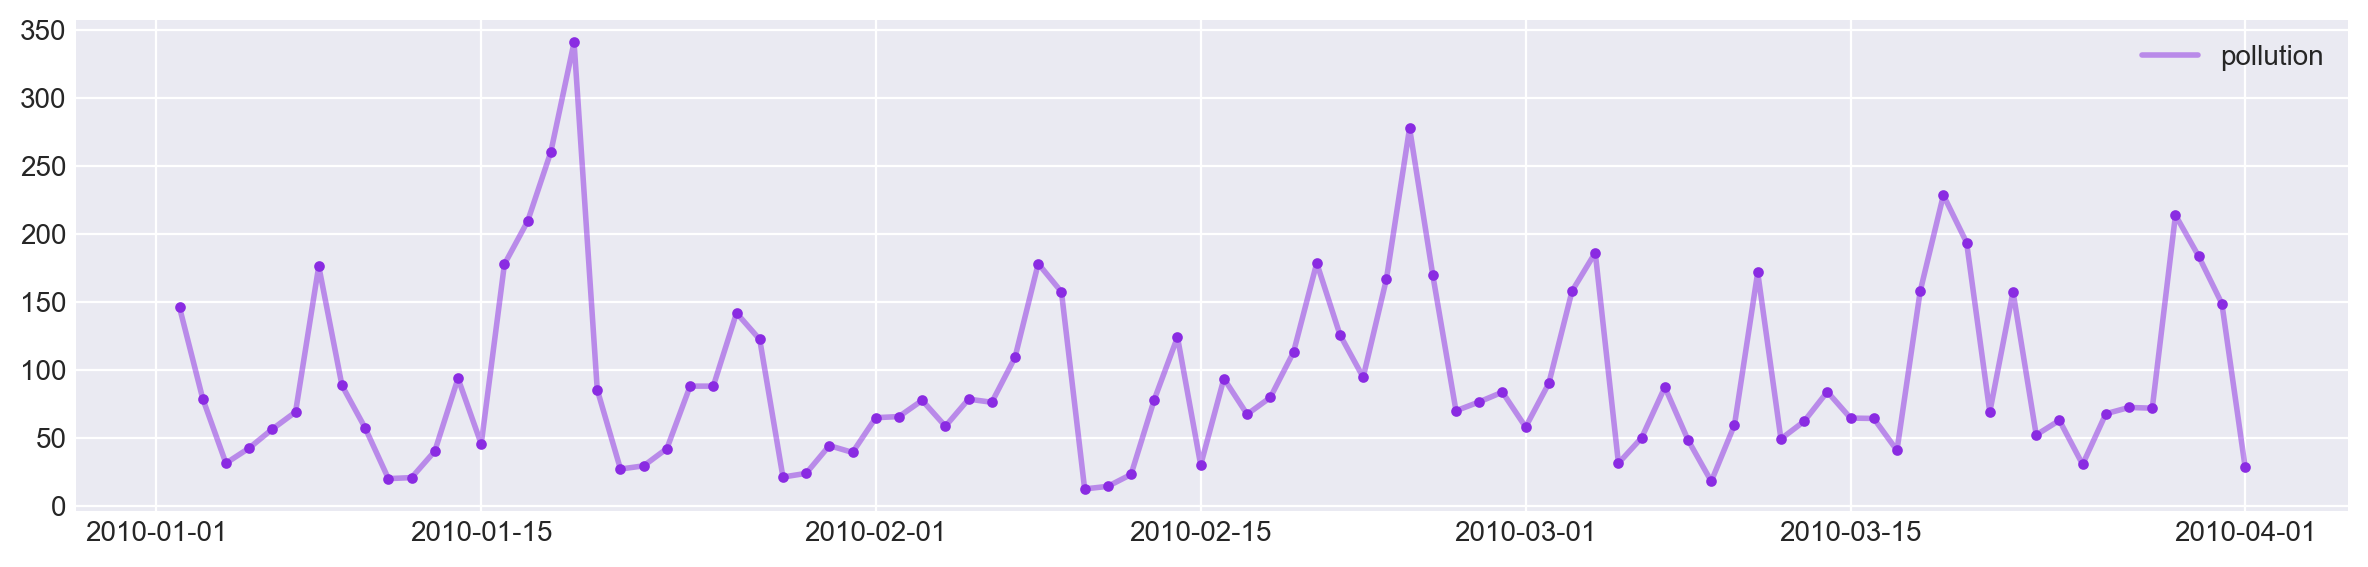

In [4]:
show_dataset(dataframe[:90], columns=["pollution"])

In [5]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "pollution"
TEST_SIZE = 30

In [6]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1825, 7)
dataframe shape after Feature Union (1822, 26)

Train Size after Test_Train Split: (1792, 26)
Test  Size after Test_Train Split: (30, 26) 

train_x shape after seperate_target (1792, 25)
train_y shape after seperate_target (1792, 1)
test_x  shape after seperate_target (30, 25)
test_y  shape after seperate_target (30, 1)


In [7]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END .........regressor__n_neighbors=2;, score=-0.157 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=2;, score=-0.088 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.198 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.035 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=3;, score=-0.016 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.294 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.115 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.119 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.341 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.173 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.183 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

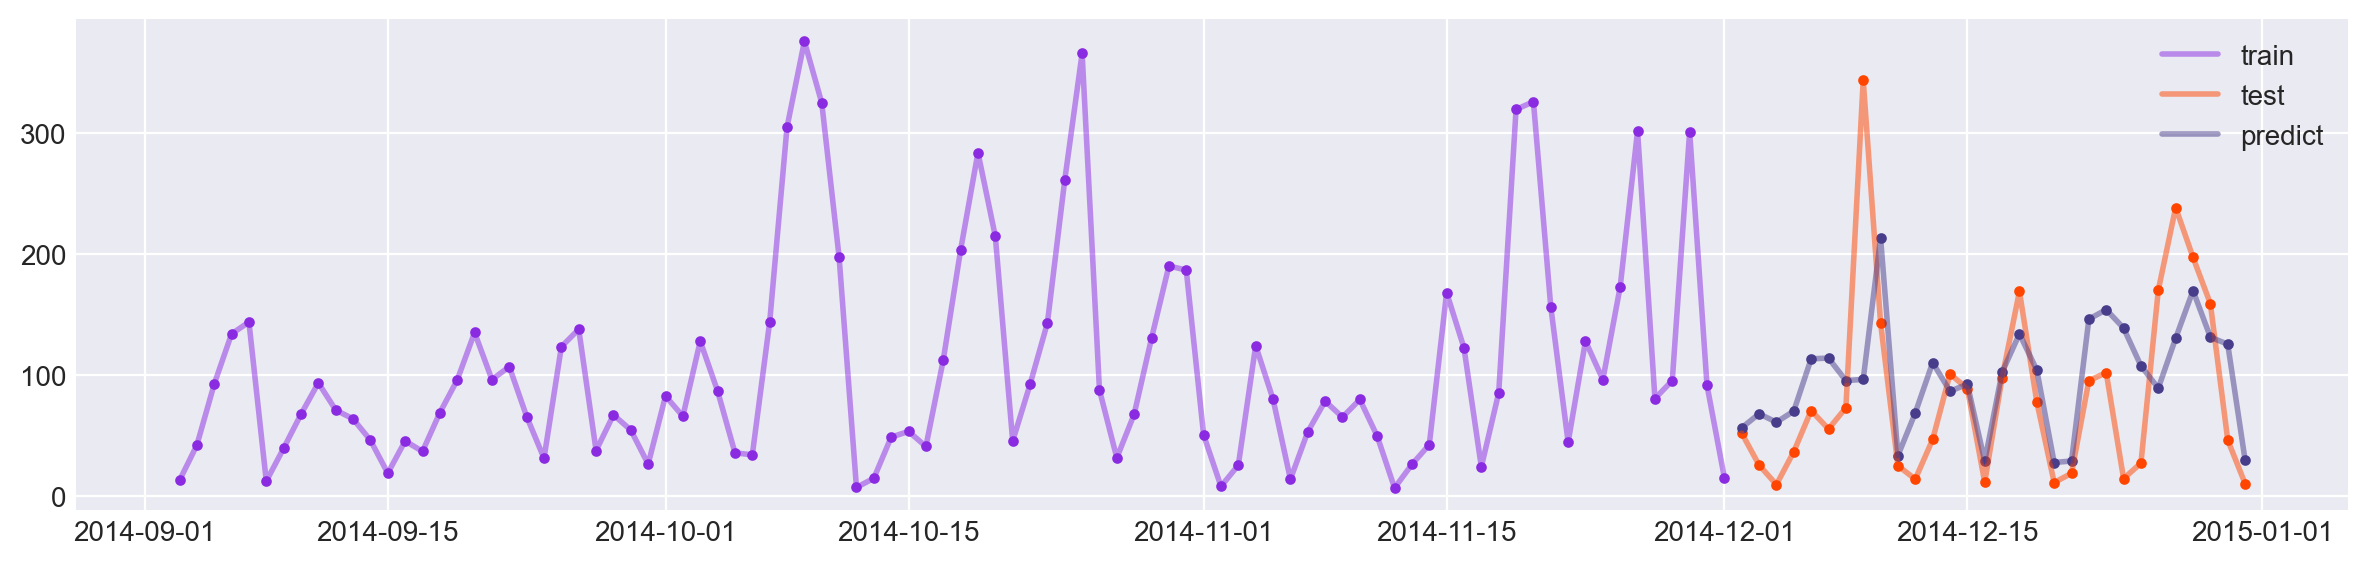

In [9]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [16]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat
print(resultsDict)

Convergence after  13  iterations
{'KNeighborsRegressor': {'mae': 49.397916666666674, 'rmse': 68.72851109170573, 'mape': 1.3127388187313787, 'r2': 0.22366341288561398}, 'BayesianRidge': {'mae': 33.699082216113965, 'rmse': 54.33466348723158, 'mape': 0.7501878245265211, 'r2': 0.5147895495264712}, 'LassoCV': {'mae': 33.35955458396462, 'rmse': 54.202627175215575, 'mape': 0.7980339823257268, 'r2': 0.51714486206733}}


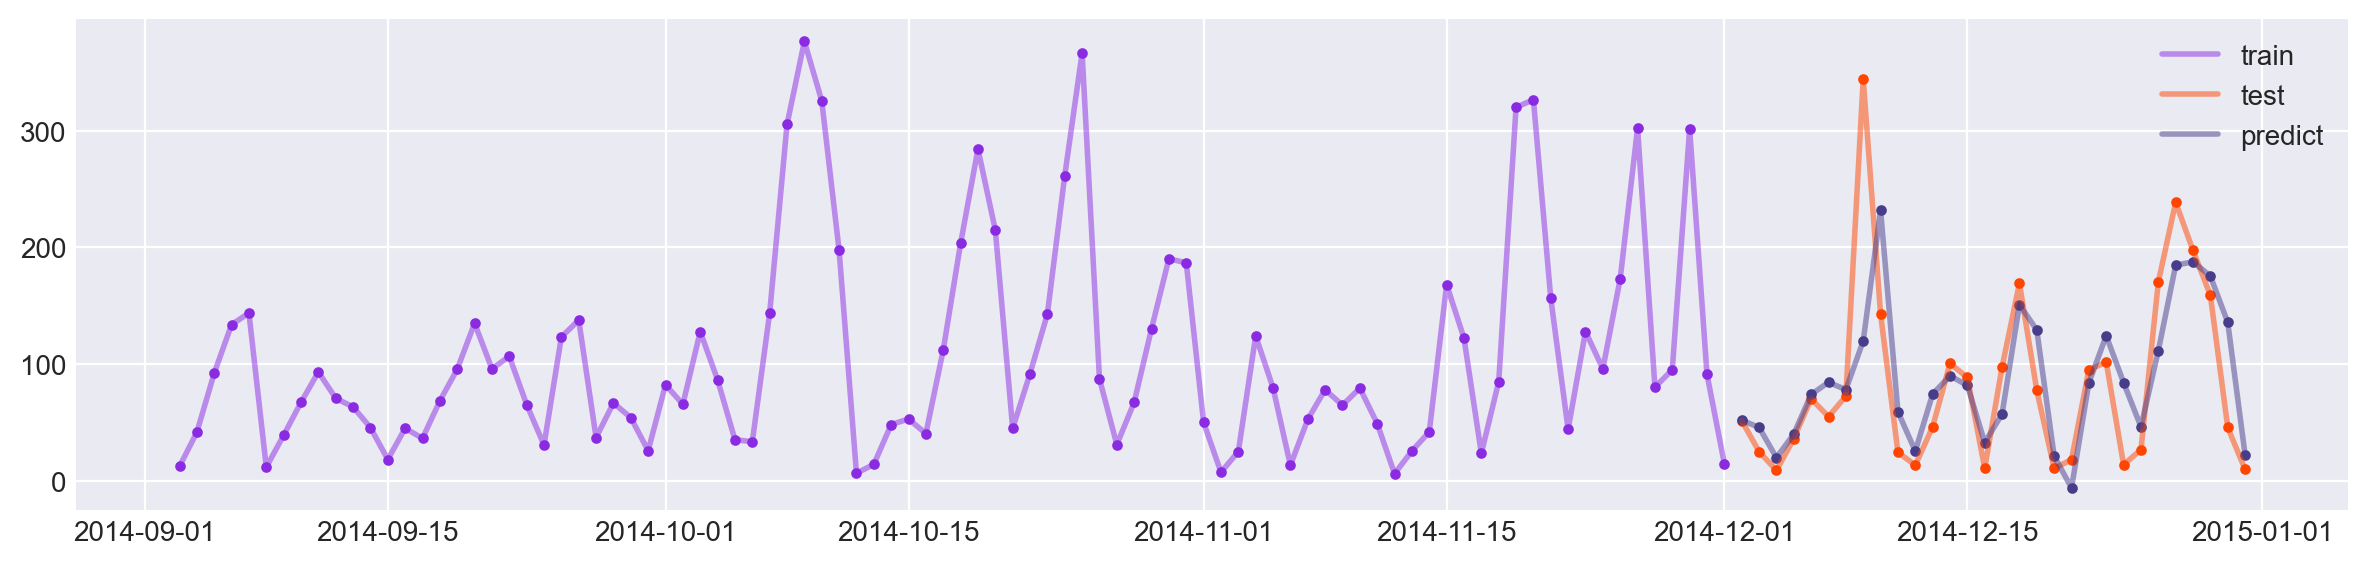

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [18]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LassoCV(fit_intercept=True, max_iter=100000)),
    ]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

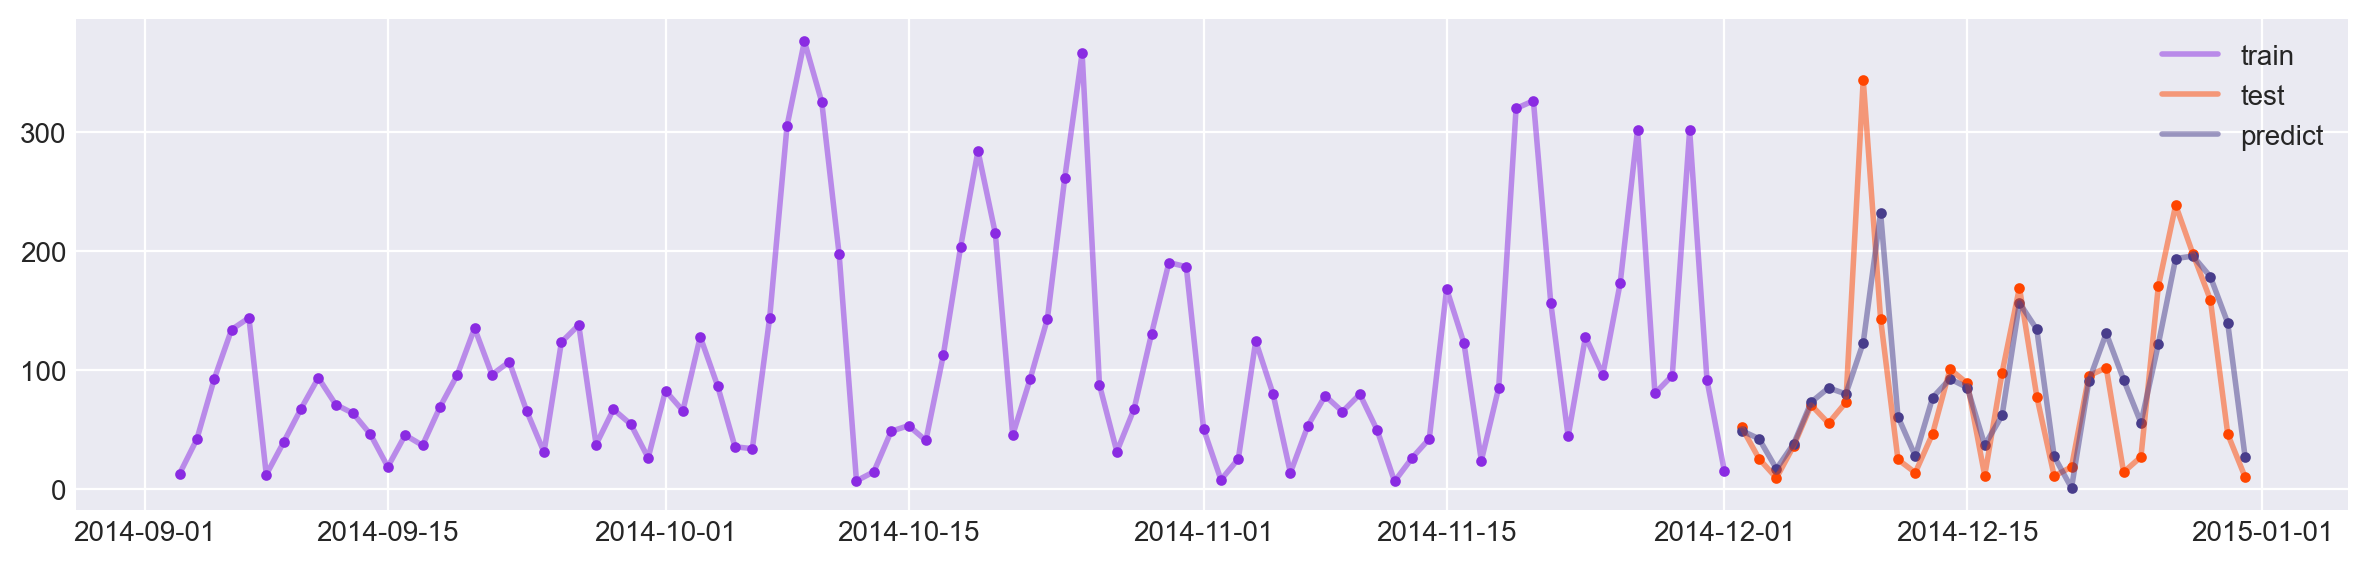

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.422 total time=   2.8s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.498 total time=   5.5s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.669 total time=   8.0s
0.5298593575331676 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}


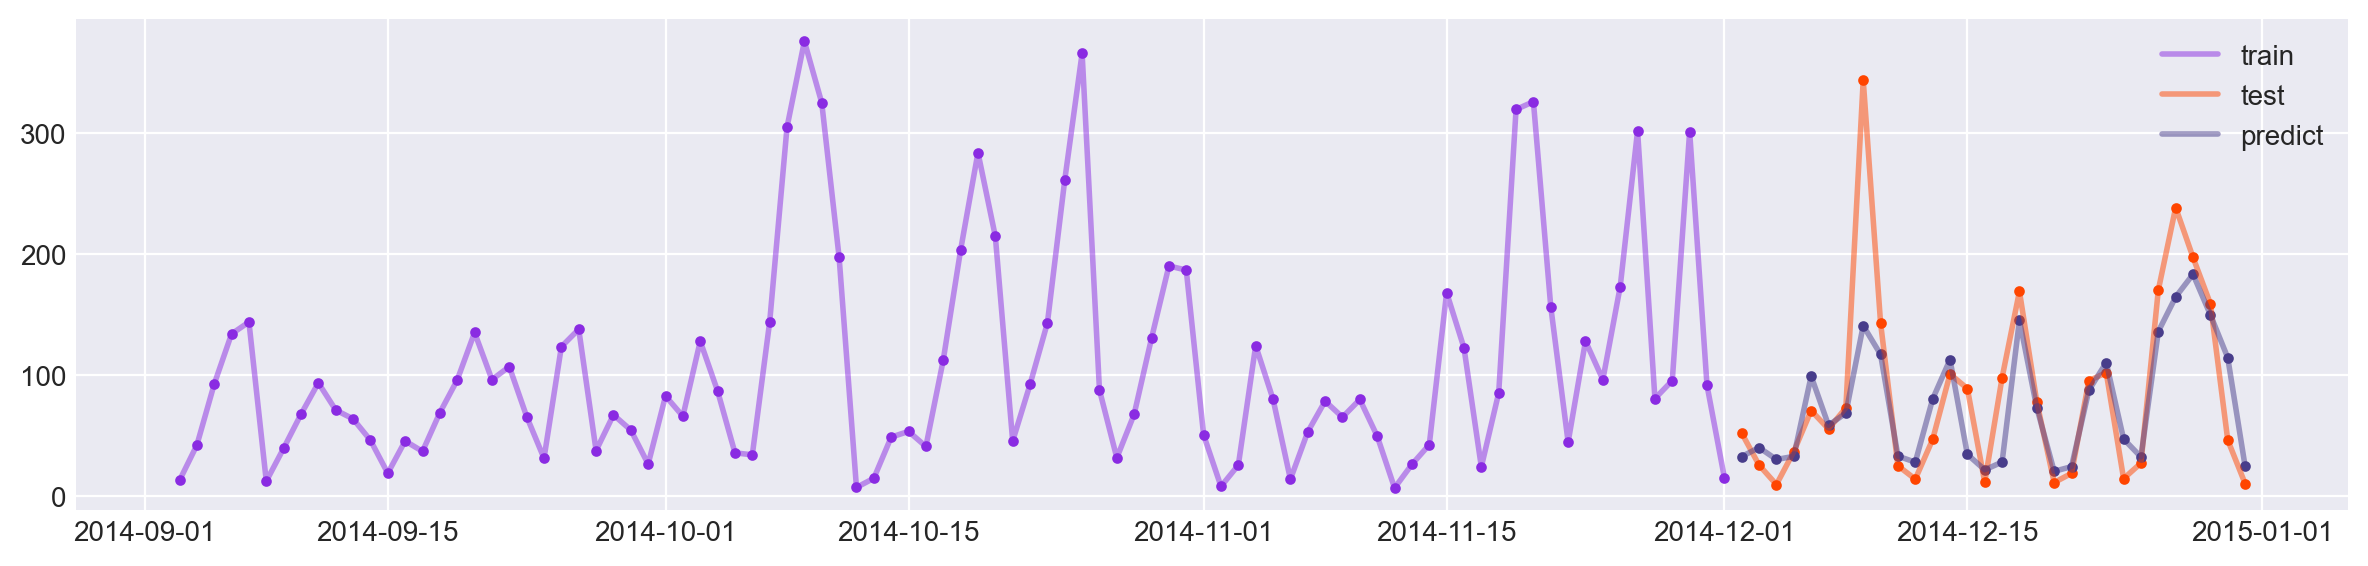

In [16]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:97.50967	validation_1-mae:83.01122
[1]	validation_0-mae:96.55950	validation_1-mae:82.34530
[2]	validation_0-mae:95.61880	validation_1-mae:81.68564
[3]	validation_0-mae:94.68709	validation_1-mae:80.99874
[4]	validation_0-mae:93.76523	validation_1-mae:80.33714
[5]	validation_0-mae:92.85208	validation_1-mae:79.65893
[6]	validation_0-mae:91.94744	validation_1-mae:79.02414
[7]	validation_0-mae:91.05296	validation_1-mae:78.31848
[8]	validation_0-mae:90.16865	validation_1-mae:77.69279
[9]	validation_0-mae:89.29405	validation_1-mae:77.06647
[10]	validation_0-mae:88.42971	validation_1-mae:76.38018
[11]	validation_0-mae:87.57216	validation_1-mae:75.78692
[12]	validation_0-mae:86.72768	validation_1-mae:75.08552
[13]	validation_0-mae:85.89313	validation_1-mae:74.47555
[14]	validation_0-mae:85.06504	validation_1-mae:73.90528
[15]	validation_0-mae:84.24598	validation_1-mae:73.34048
[16]	validation_0-mae:83.43712	validation_1-mae:72.64946
[17]	validation_0-mae:82.63836	validation

[144]	validation_0-mae:33.10162	validation_1-mae:38.70434
[145]	validation_0-mae:32.94841	validation_1-mae:38.56704
[146]	validation_0-mae:32.79214	validation_1-mae:38.42410
[147]	validation_0-mae:32.64464	validation_1-mae:38.28946
[148]	validation_0-mae:32.48798	validation_1-mae:38.16312
[149]	validation_0-mae:32.34481	validation_1-mae:38.05611
[150]	validation_0-mae:32.20103	validation_1-mae:37.88378
[151]	validation_0-mae:32.04877	validation_1-mae:37.73894
[152]	validation_0-mae:31.91150	validation_1-mae:37.61142
[153]	validation_0-mae:31.76106	validation_1-mae:37.49341
[154]	validation_0-mae:31.62425	validation_1-mae:37.35177
[155]	validation_0-mae:31.47872	validation_1-mae:37.20807
[156]	validation_0-mae:31.34826	validation_1-mae:37.10204
[157]	validation_0-mae:31.22103	validation_1-mae:36.99692
[158]	validation_0-mae:31.09857	validation_1-mae:36.91869
[159]	validation_0-mae:30.96711	validation_1-mae:36.79237
[160]	validation_0-mae:30.84844	validation_1-mae:36.70938
[161]	validati

[286]	validation_0-mae:22.33980	validation_1-mae:31.03543
[287]	validation_0-mae:22.30961	validation_1-mae:31.01691
[288]	validation_0-mae:22.27992	validation_1-mae:30.99482
[289]	validation_0-mae:22.24279	validation_1-mae:30.97876
[290]	validation_0-mae:22.20462	validation_1-mae:30.90120
[291]	validation_0-mae:22.17625	validation_1-mae:30.88822
[292]	validation_0-mae:22.14776	validation_1-mae:30.87424
[293]	validation_0-mae:22.11490	validation_1-mae:30.86651
[294]	validation_0-mae:22.08741	validation_1-mae:30.85279
[295]	validation_0-mae:22.05357	validation_1-mae:30.82419
[296]	validation_0-mae:22.01767	validation_1-mae:30.80990
[297]	validation_0-mae:21.98507	validation_1-mae:30.80130
[298]	validation_0-mae:21.95417	validation_1-mae:30.79063
[299]	validation_0-mae:21.92977	validation_1-mae:30.76753
[300]	validation_0-mae:21.89852	validation_1-mae:30.75896
[301]	validation_0-mae:21.86332	validation_1-mae:30.74506
[302]	validation_0-mae:21.83350	validation_1-mae:30.72705
[303]	validati

[428]	validation_0-mae:18.68546	validation_1-mae:29.38776
[429]	validation_0-mae:18.66282	validation_1-mae:29.36183
[430]	validation_0-mae:18.64379	validation_1-mae:29.35590
[431]	validation_0-mae:18.62099	validation_1-mae:29.35713
[432]	validation_0-mae:18.60810	validation_1-mae:29.35318
[433]	validation_0-mae:18.58735	validation_1-mae:29.32460
[434]	validation_0-mae:18.56913	validation_1-mae:29.31876
[435]	validation_0-mae:18.54732	validation_1-mae:29.31846
[436]	validation_0-mae:18.53498	validation_1-mae:29.31250
[437]	validation_0-mae:18.50567	validation_1-mae:29.31373
[438]	validation_0-mae:18.48166	validation_1-mae:29.28854
[439]	validation_0-mae:18.45980	validation_1-mae:29.27542
[440]	validation_0-mae:18.44664	validation_1-mae:29.27697
[441]	validation_0-mae:18.42654	validation_1-mae:29.24916
[442]	validation_0-mae:18.41051	validation_1-mae:29.24668
[443]	validation_0-mae:18.39068	validation_1-mae:29.21718
[444]	validation_0-mae:18.37533	validation_1-mae:29.21327
[445]	validati

[570]	validation_0-mae:16.13422	validation_1-mae:28.87911
[571]	validation_0-mae:16.11701	validation_1-mae:28.87972
[572]	validation_0-mae:16.09779	validation_1-mae:28.87923
[573]	validation_0-mae:16.08316	validation_1-mae:28.87982
[574]	validation_0-mae:16.06627	validation_1-mae:28.89277
[575]	validation_0-mae:16.04469	validation_1-mae:28.89002
[576]	validation_0-mae:16.03298	validation_1-mae:28.89063
[577]	validation_0-mae:16.01415	validation_1-mae:28.89663


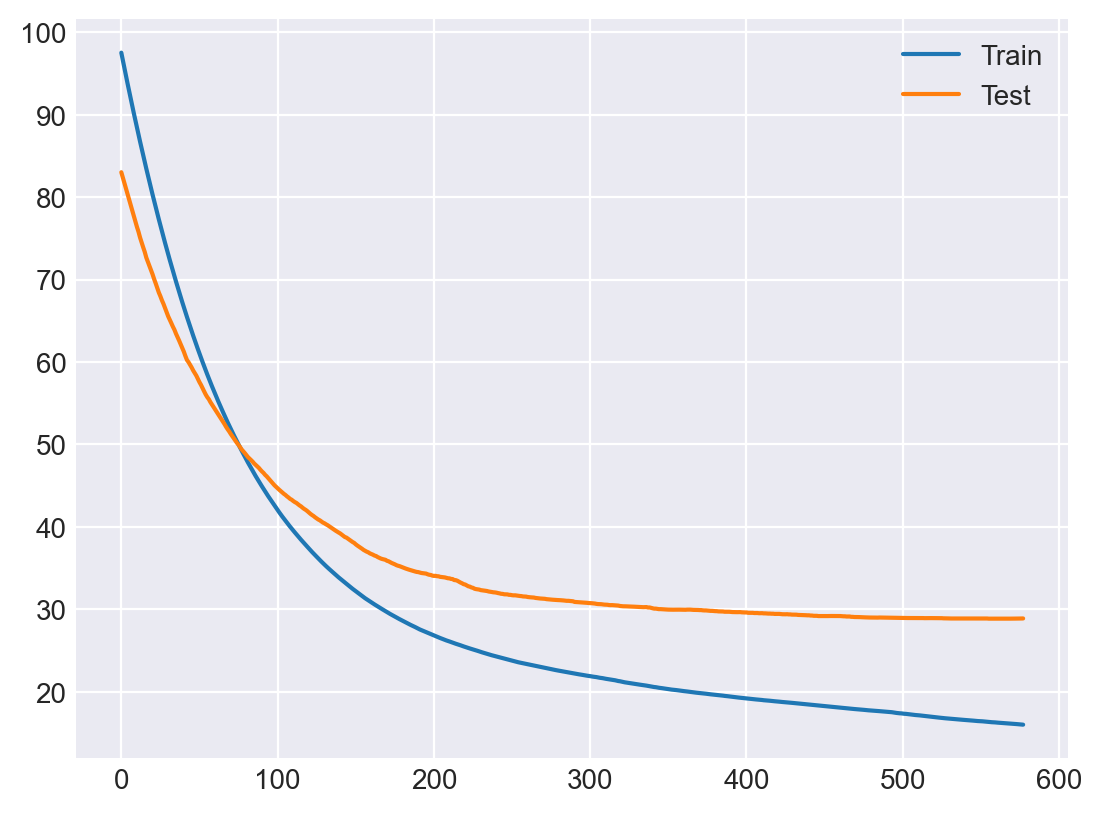

In [17]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

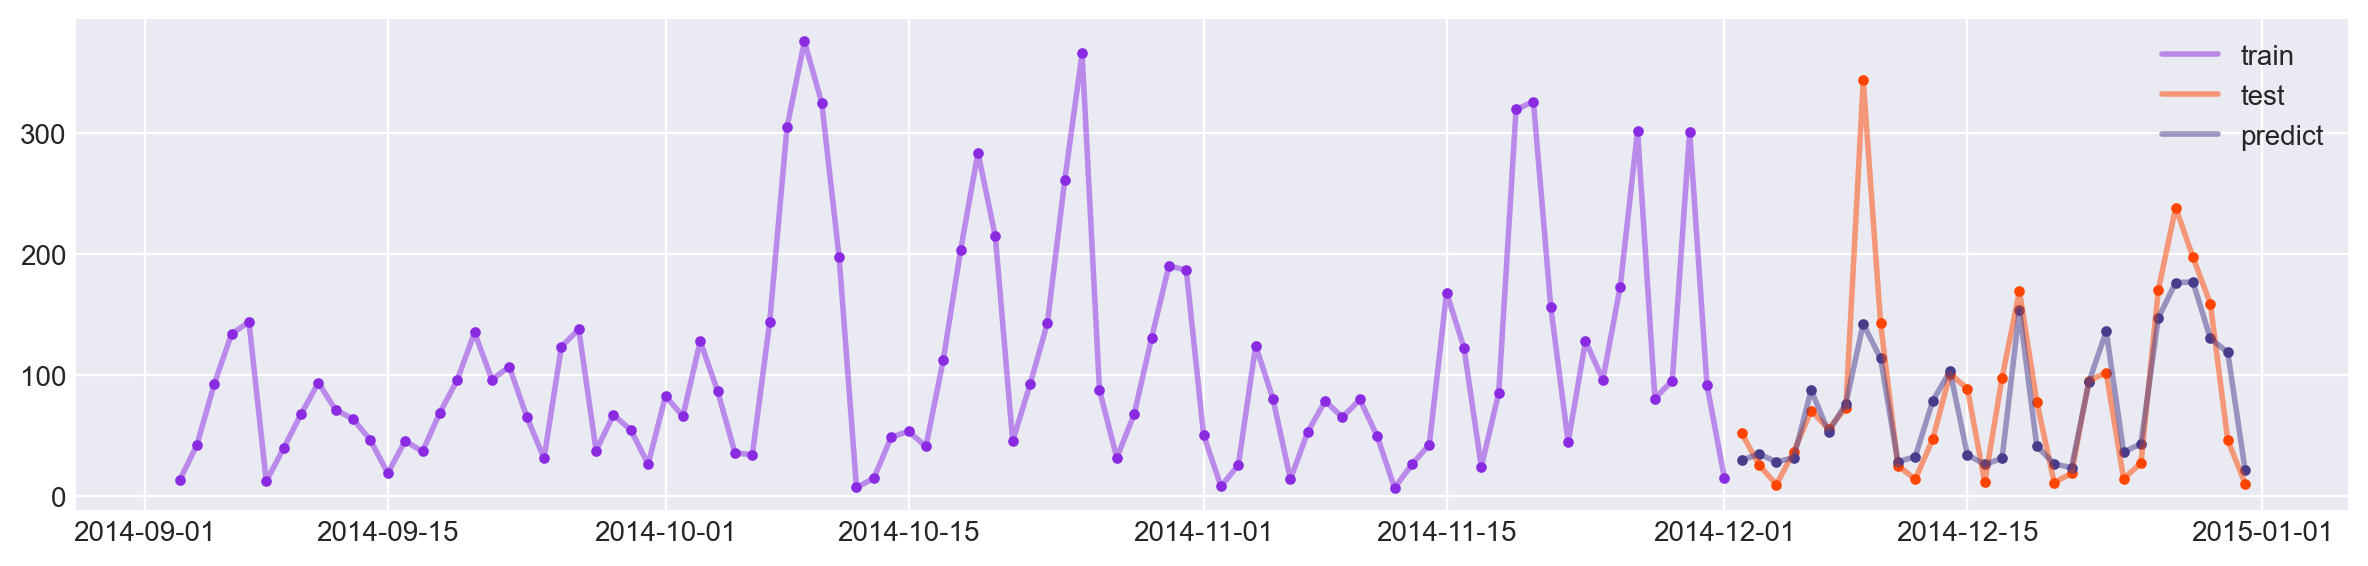

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [19]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 54.7667	training's l2: 5276.32	valid_1's l1: 59.925	valid_1's l2: 5689.5
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 51.8439	training's l2: 4694.45	valid_1's l1: 56.4646	valid_1's l2: 5130.72
[3]	training's l1: 49.2473	training's l2: 4213.4	valid_1's l1: 54.1272	valid_1's l2: 4752.23
[4]	training's l1: 46.8975	training's l2: 3792.05	valid_1's l1: 51.2888	valid_1's l2: 4372.97
[5]	training's l1: 44.7251	training's l2: 3431.11	valid_1's l1: 49.4917	valid_1's l2: 4109.77
[6]	training's l1: 42.8526	training's l2: 3133.08	valid_1's l1: 47.1326	valid_1's l2: 3847.06
[7]	training's l1: 41.2606	training's l2: 2887.6	valid_1's l1: 44.8656	valid_1's l2: 3644.41
[8]	training's l1: 39.687	training's l2: 2670.12	valid_1's l1: 43.4606	valid_1's l2: 3473.51
[9]	training's l1: 38.3635	training's l2: 2485.3	valid_1's l1: 41.112	valid_1's l2: 3173.01
[10]	training's l1: 37.1044	training's l2: 2319.4	valid_1's l1: 39.5561	valid_1's l2: 3005.3
[11]	

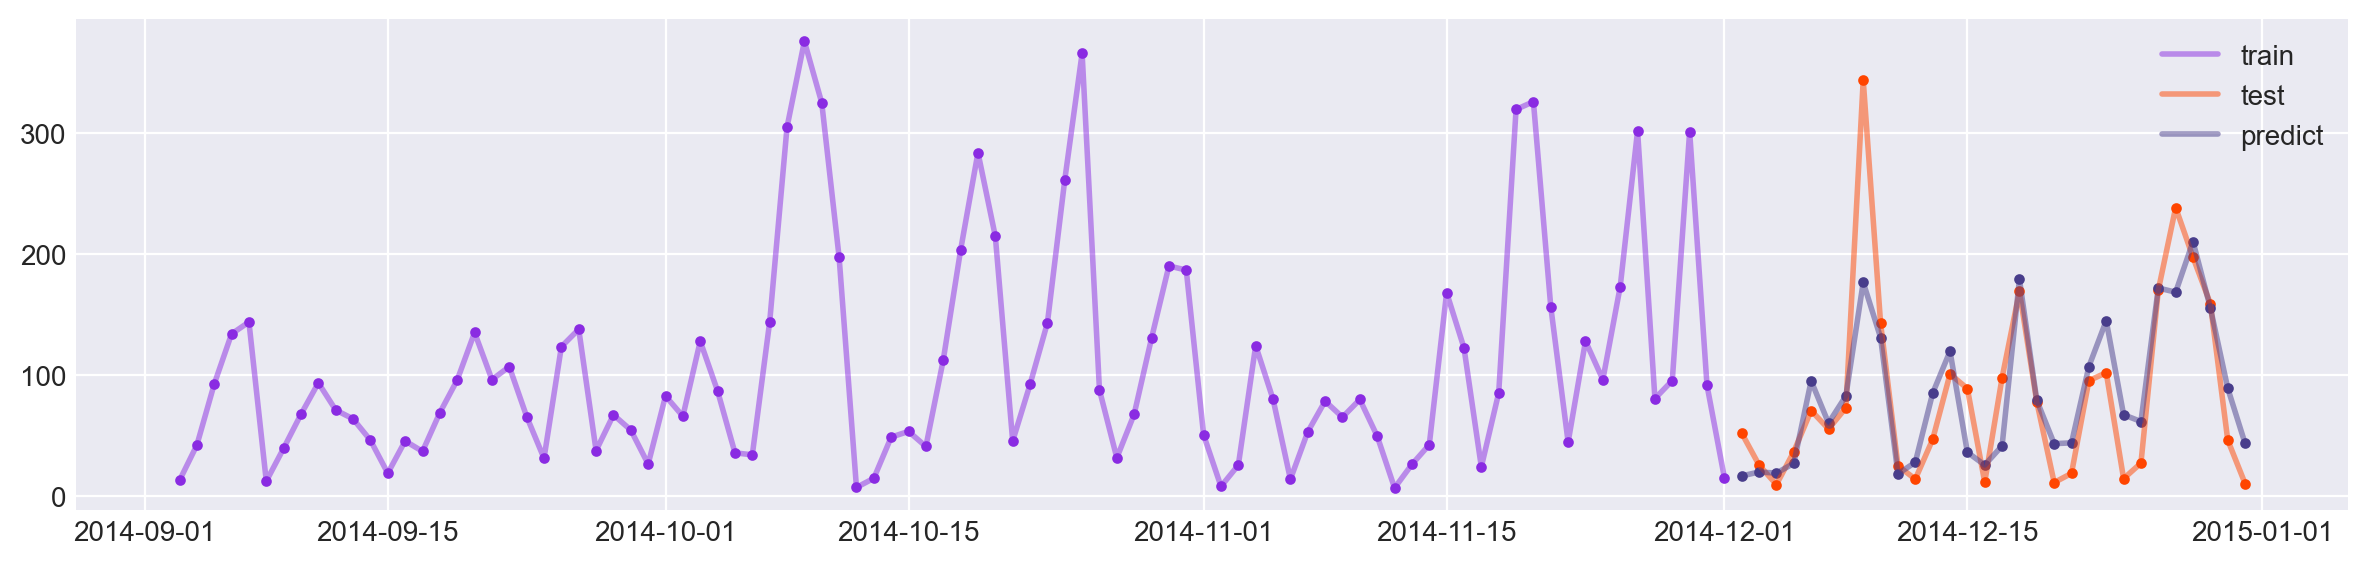

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [21]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 116.3415849	test: 119.0673866	best: 119.0673866 (0)	total: 167ms	remaining: 2m 46s
1:	learn: 108.9416806	test: 111.7800186	best: 111.7800186 (1)	total: 170ms	remaining: 1m 24s
2:	learn: 102.5520444	test: 105.2861793	best: 105.2861793 (2)	total: 171ms	remaining: 57s
3:	learn: 96.5472865	test: 99.2640143	best: 99.2640143 (3)	total: 173ms	remaining: 43.1s
4:	learn: 91.2189885	test: 94.1580994	best: 94.1580994 (4)	total: 174ms	remaining: 34.6s
5:	learn: 86.4207785	test: 89.6879513	best: 89.6879513 (5)	total: 175ms	remaining: 29s
6:	learn: 81.8211191	test: 84.7026541	best: 84.7026541 (6)	total: 176ms	remaining: 24.9s
7:	learn: 78.4571217	test: 81.4419587	best: 81.4419587 (7)	total: 177ms	remaining: 21.9s
8:	learn: 75.1365097	test: 78.1629745	best: 78.1629745 (8)	total: 178ms	remaining: 19.6s
9:	learn: 72.6355056	test: 75.8530974	best: 75.8530974 (9)	total: 179ms	remaining: 17.7s
10:	learn: 70.0293054	test: 73.2649605	best: 73.2649605 (10)	total: 179ms	remaining: 16.1s
11:	learn: 6

192:	learn: 32.6510166	test: 42.2138718	best: 42.1563813 (189)	total: 571ms	remaining: 2.39s
193:	learn: 32.6014758	test: 42.2072684	best: 42.1563813 (189)	total: 572ms	remaining: 2.38s
194:	learn: 32.5609277	test: 42.2065863	best: 42.1563813 (189)	total: 573ms	remaining: 2.37s
195:	learn: 32.5248886	test: 42.2332129	best: 42.1563813 (189)	total: 574ms	remaining: 2.35s
196:	learn: 32.4862334	test: 42.2434184	best: 42.1563813 (189)	total: 575ms	remaining: 2.34s
197:	learn: 32.4474905	test: 42.2192363	best: 42.1563813 (189)	total: 577ms	remaining: 2.34s
198:	learn: 32.3801082	test: 42.2243948	best: 42.1563813 (189)	total: 579ms	remaining: 2.33s
199:	learn: 32.3016062	test: 42.3176418	best: 42.1563813 (189)	total: 580ms	remaining: 2.32s
200:	learn: 32.2373266	test: 42.2885101	best: 42.1563813 (189)	total: 581ms	remaining: 2.31s
201:	learn: 32.1484531	test: 42.2526672	best: 42.1563813 (189)	total: 582ms	remaining: 2.3s
202:	learn: 32.1139000	test: 42.2613855	best: 42.1563813 (189)	total: 5

292:	learn: 28.0345878	test: 41.3092755	best: 41.1296468 (280)	total: 770ms	remaining: 1.86s
293:	learn: 27.9986301	test: 41.3022048	best: 41.1296468 (280)	total: 771ms	remaining: 1.85s
294:	learn: 27.9490344	test: 41.3200954	best: 41.1296468 (280)	total: 772ms	remaining: 1.84s
295:	learn: 27.9103670	test: 41.3116859	best: 41.1296468 (280)	total: 773ms	remaining: 1.84s
296:	learn: 27.8673718	test: 41.3317284	best: 41.1296468 (280)	total: 774ms	remaining: 1.83s
297:	learn: 27.8310895	test: 41.3122478	best: 41.1296468 (280)	total: 775ms	remaining: 1.82s
298:	learn: 27.7935039	test: 41.3167023	best: 41.1296468 (280)	total: 776ms	remaining: 1.82s
299:	learn: 27.7682258	test: 41.3069065	best: 41.1296468 (280)	total: 777ms	remaining: 1.81s
300:	learn: 27.7506140	test: 41.2930513	best: 41.1296468 (280)	total: 778ms	remaining: 1.81s
301:	learn: 27.7318502	test: 41.2718757	best: 41.1296468 (280)	total: 779ms	remaining: 1.8s
302:	learn: 27.6682095	test: 41.2513051	best: 41.1296468 (280)	total: 7

400:	learn: 24.6499368	test: 40.8243376	best: 40.8243376 (400)	total: 970ms	remaining: 1.45s
401:	learn: 24.6181751	test: 40.8018718	best: 40.8018718 (401)	total: 971ms	remaining: 1.44s
402:	learn: 24.5986571	test: 40.8046458	best: 40.8018718 (401)	total: 972ms	remaining: 1.44s
403:	learn: 24.5595748	test: 40.7935168	best: 40.7935168 (403)	total: 973ms	remaining: 1.44s
404:	learn: 24.5385433	test: 40.7920043	best: 40.7920043 (404)	total: 974ms	remaining: 1.43s
405:	learn: 24.5003404	test: 40.7933227	best: 40.7920043 (404)	total: 974ms	remaining: 1.43s
406:	learn: 24.4834610	test: 40.7960187	best: 40.7920043 (404)	total: 975ms	remaining: 1.42s
407:	learn: 24.4595548	test: 40.8122655	best: 40.7920043 (404)	total: 976ms	remaining: 1.42s
408:	learn: 24.4199755	test: 40.8468002	best: 40.7920043 (404)	total: 977ms	remaining: 1.41s
409:	learn: 24.3967711	test: 40.8327673	best: 40.7920043 (404)	total: 978ms	remaining: 1.41s
410:	learn: 24.3697903	test: 40.8312458	best: 40.7920043 (404)	total: 

504:	learn: 22.0085909	test: 40.6405019	best: 40.5899459 (468)	total: 1.17s	remaining: 1.15s
505:	learn: 21.9825940	test: 40.6478288	best: 40.5899459 (468)	total: 1.17s	remaining: 1.14s
506:	learn: 21.9495545	test: 40.6281957	best: 40.5899459 (468)	total: 1.17s	remaining: 1.14s
507:	learn: 21.9148541	test: 40.6202384	best: 40.5899459 (468)	total: 1.17s	remaining: 1.14s
508:	learn: 21.8891427	test: 40.6030491	best: 40.5899459 (468)	total: 1.18s	remaining: 1.13s
509:	learn: 21.8589493	test: 40.5873342	best: 40.5873342 (509)	total: 1.18s	remaining: 1.13s
510:	learn: 21.8204425	test: 40.5911630	best: 40.5873342 (509)	total: 1.18s	remaining: 1.13s
511:	learn: 21.8106610	test: 40.5958127	best: 40.5873342 (509)	total: 1.18s	remaining: 1.12s
512:	learn: 21.8017252	test: 40.5954267	best: 40.5873342 (509)	total: 1.18s	remaining: 1.12s
513:	learn: 21.7837713	test: 40.6092035	best: 40.5873342 (509)	total: 1.18s	remaining: 1.12s
514:	learn: 21.7543623	test: 40.6095229	best: 40.5873342 (509)	total: 

633:	learn: 19.5513164	test: 40.8434223	best: 40.5840120 (524)	total: 1.37s	remaining: 792ms
634:	learn: 19.5239356	test: 40.8467338	best: 40.5840120 (524)	total: 1.37s	remaining: 789ms
635:	learn: 19.5070128	test: 40.8615969	best: 40.5840120 (524)	total: 1.37s	remaining: 786ms
636:	learn: 19.4908485	test: 40.8649373	best: 40.5840120 (524)	total: 1.37s	remaining: 783ms
637:	learn: 19.4738937	test: 40.8662386	best: 40.5840120 (524)	total: 1.38s	remaining: 781ms
638:	learn: 19.4641383	test: 40.8854015	best: 40.5840120 (524)	total: 1.38s	remaining: 778ms
639:	learn: 19.4546994	test: 40.8903900	best: 40.5840120 (524)	total: 1.38s	remaining: 775ms
640:	learn: 19.4510158	test: 40.8930794	best: 40.5840120 (524)	total: 1.38s	remaining: 772ms
641:	learn: 19.4506542	test: 40.8934303	best: 40.5840120 (524)	total: 1.38s	remaining: 769ms
642:	learn: 19.4365575	test: 40.9011489	best: 40.5840120 (524)	total: 1.38s	remaining: 766ms
643:	learn: 19.4124397	test: 40.8831495	best: 40.5840120 (524)	total: 

811:	learn: 16.6722788	test: 40.8732345	best: 40.5840120 (524)	total: 1.77s	remaining: 411ms
812:	learn: 16.6573277	test: 40.8701728	best: 40.5840120 (524)	total: 1.77s	remaining: 408ms
813:	learn: 16.6290487	test: 40.9094267	best: 40.5840120 (524)	total: 1.77s	remaining: 406ms
814:	learn: 16.6051922	test: 40.9206933	best: 40.5840120 (524)	total: 1.78s	remaining: 403ms
815:	learn: 16.5893659	test: 40.9176338	best: 40.5840120 (524)	total: 1.78s	remaining: 401ms
816:	learn: 16.5726582	test: 40.9284025	best: 40.5840120 (524)	total: 1.78s	remaining: 398ms
817:	learn: 16.5554601	test: 40.9322421	best: 40.5840120 (524)	total: 1.78s	remaining: 396ms
818:	learn: 16.5433561	test: 40.9456101	best: 40.5840120 (524)	total: 1.78s	remaining: 393ms
819:	learn: 16.5230729	test: 40.9300755	best: 40.5840120 (524)	total: 1.78s	remaining: 391ms
820:	learn: 16.5103511	test: 40.9370692	best: 40.5840120 (524)	total: 1.78s	remaining: 389ms
821:	learn: 16.4986794	test: 40.9367827	best: 40.5840120 (524)	total: 

986:	learn: 14.3676435	test: 40.8932462	best: 40.5840120 (524)	total: 2.18s	remaining: 28.7ms
987:	learn: 14.3492367	test: 40.9005975	best: 40.5840120 (524)	total: 2.18s	remaining: 26.4ms
988:	learn: 14.3402654	test: 40.9087396	best: 40.5840120 (524)	total: 2.18s	remaining: 24.2ms
989:	learn: 14.3331725	test: 40.9037090	best: 40.5840120 (524)	total: 2.18s	remaining: 22ms
990:	learn: 14.3181650	test: 40.9113473	best: 40.5840120 (524)	total: 2.18s	remaining: 19.8ms
991:	learn: 14.2995311	test: 40.9079952	best: 40.5840120 (524)	total: 2.18s	remaining: 17.6ms
992:	learn: 14.2864225	test: 40.9007732	best: 40.5840120 (524)	total: 2.18s	remaining: 15.4ms
993:	learn: 14.2706691	test: 40.9135422	best: 40.5840120 (524)	total: 2.18s	remaining: 13.2ms
994:	learn: 14.2652972	test: 40.9141058	best: 40.5840120 (524)	total: 2.18s	remaining: 11ms
995:	learn: 14.2538774	test: 40.9028239	best: 40.5840120 (524)	total: 2.18s	remaining: 8.77ms
996:	learn: 14.2479579	test: 40.9048324	best: 40.5840120 (524)	t

127:	learn: 37.9412756	test: 43.2879330	best: 43.2879330 (127)	total: 380ms	remaining: 2.59s
128:	learn: 37.8967142	test: 43.2939249	best: 43.2879330 (127)	total: 381ms	remaining: 2.57s
129:	learn: 37.8591881	test: 43.2898678	best: 43.2879330 (127)	total: 382ms	remaining: 2.56s
130:	learn: 37.8081613	test: 43.3038058	best: 43.2879330 (127)	total: 383ms	remaining: 2.54s
131:	learn: 37.7144123	test: 43.2268893	best: 43.2268893 (131)	total: 384ms	remaining: 2.52s
132:	learn: 37.6292667	test: 43.2081800	best: 43.2081800 (132)	total: 385ms	remaining: 2.51s
133:	learn: 37.5583473	test: 43.2186678	best: 43.2081800 (132)	total: 386ms	remaining: 2.49s
134:	learn: 37.4415480	test: 43.1892021	best: 43.1892021 (134)	total: 387ms	remaining: 2.48s
135:	learn: 37.3792498	test: 43.1694367	best: 43.1694367 (135)	total: 388ms	remaining: 2.46s
136:	learn: 37.3216926	test: 43.1410617	best: 43.1410617 (136)	total: 389ms	remaining: 2.45s
137:	learn: 37.2427211	test: 43.0912012	best: 43.0912012 (137)	total: 

282:	learn: 29.7308779	test: 40.8494017	best: 40.8216426 (280)	total: 785ms	remaining: 1.99s
283:	learn: 29.6756234	test: 40.8546490	best: 40.8216426 (280)	total: 786ms	remaining: 1.98s
284:	learn: 29.6375450	test: 40.8866979	best: 40.8216426 (280)	total: 787ms	remaining: 1.97s
285:	learn: 29.6177220	test: 40.8684154	best: 40.8216426 (280)	total: 788ms	remaining: 1.97s
286:	learn: 29.5623078	test: 40.8534415	best: 40.8216426 (280)	total: 788ms	remaining: 1.96s
287:	learn: 29.4893961	test: 40.8512620	best: 40.8216426 (280)	total: 789ms	remaining: 1.95s
288:	learn: 29.4578472	test: 40.8431020	best: 40.8216426 (280)	total: 790ms	remaining: 1.94s
289:	learn: 29.4082321	test: 40.8599478	best: 40.8216426 (280)	total: 791ms	remaining: 1.94s
290:	learn: 29.3752495	test: 40.8717934	best: 40.8216426 (280)	total: 792ms	remaining: 1.93s
291:	learn: 29.3487719	test: 40.8469725	best: 40.8216426 (280)	total: 793ms	remaining: 1.92s
292:	learn: 29.2897547	test: 40.8566682	best: 40.8216426 (280)	total: 

394:	learn: 26.0289045	test: 40.5574033	best: 40.5487555 (391)	total: 987ms	remaining: 1.51s
395:	learn: 26.0092691	test: 40.5484101	best: 40.5484101 (395)	total: 988ms	remaining: 1.51s
396:	learn: 25.9634732	test: 40.5739045	best: 40.5484101 (395)	total: 989ms	remaining: 1.5s
397:	learn: 25.9083439	test: 40.5742933	best: 40.5484101 (395)	total: 990ms	remaining: 1.5s
398:	learn: 25.8671008	test: 40.5981441	best: 40.5484101 (395)	total: 991ms	remaining: 1.49s
399:	learn: 25.8464376	test: 40.5915053	best: 40.5484101 (395)	total: 992ms	remaining: 1.49s
400:	learn: 25.8203265	test: 40.5875924	best: 40.5484101 (395)	total: 993ms	remaining: 1.48s
401:	learn: 25.8004526	test: 40.5883721	best: 40.5484101 (395)	total: 994ms	remaining: 1.48s
402:	learn: 25.7723564	test: 40.5931923	best: 40.5484101 (395)	total: 995ms	remaining: 1.47s
403:	learn: 25.7457507	test: 40.6166787	best: 40.5484101 (395)	total: 996ms	remaining: 1.47s
404:	learn: 25.7179198	test: 40.6155875	best: 40.5484101 (395)	total: 99

553:	learn: 22.2526188	test: 40.5210219	best: 40.4878572 (479)	total: 1.4s	remaining: 1.12s
554:	learn: 22.2176980	test: 40.5180832	best: 40.4878572 (479)	total: 1.4s	remaining: 1.12s
555:	learn: 22.1871243	test: 40.5347976	best: 40.4878572 (479)	total: 1.4s	remaining: 1.11s
556:	learn: 22.1847278	test: 40.5333142	best: 40.4878572 (479)	total: 1.4s	remaining: 1.11s
557:	learn: 22.1775613	test: 40.5296944	best: 40.4878572 (479)	total: 1.4s	remaining: 1.11s
558:	learn: 22.1677973	test: 40.5244203	best: 40.4878572 (479)	total: 1.4s	remaining: 1.1s
559:	learn: 22.1455144	test: 40.5158965	best: 40.4878572 (479)	total: 1.4s	remaining: 1.1s
560:	learn: 22.1147605	test: 40.5318361	best: 40.4878572 (479)	total: 1.4s	remaining: 1.1s
561:	learn: 22.0850908	test: 40.5341366	best: 40.4878572 (479)	total: 1.4s	remaining: 1.09s
562:	learn: 22.0614289	test: 40.5446451	best: 40.4878572 (479)	total: 1.4s	remaining: 1.09s
563:	learn: 22.0461408	test: 40.5537230	best: 40.4878572 (479)	total: 1.4s	remainin

644:	learn: 20.5958267	test: 40.6179338	best: 40.4868247 (590)	total: 1.61s	remaining: 885ms
645:	learn: 20.5774421	test: 40.6449399	best: 40.4868247 (590)	total: 1.61s	remaining: 881ms
646:	learn: 20.5530572	test: 40.6298390	best: 40.4868247 (590)	total: 1.61s	remaining: 878ms
647:	learn: 20.5523190	test: 40.6293251	best: 40.4868247 (590)	total: 1.61s	remaining: 875ms
648:	learn: 20.5323548	test: 40.6132978	best: 40.4868247 (590)	total: 1.61s	remaining: 871ms
649:	learn: 20.5226788	test: 40.6198127	best: 40.4868247 (590)	total: 1.61s	remaining: 868ms
650:	learn: 20.5088536	test: 40.6200178	best: 40.4868247 (590)	total: 1.61s	remaining: 865ms
651:	learn: 20.4917578	test: 40.6192972	best: 40.4868247 (590)	total: 1.61s	remaining: 861ms
652:	learn: 20.4629984	test: 40.6168295	best: 40.4868247 (590)	total: 1.61s	remaining: 858ms
653:	learn: 20.4312126	test: 40.6107117	best: 40.4868247 (590)	total: 1.61s	remaining: 855ms
654:	learn: 20.4157539	test: 40.6196554	best: 40.4868247 (590)	total: 

737:	learn: 18.9748716	test: 40.5303360	best: 40.4868247 (590)	total: 1.81s	remaining: 642ms
738:	learn: 18.9562152	test: 40.5387077	best: 40.4868247 (590)	total: 1.81s	remaining: 639ms
739:	learn: 18.9271686	test: 40.5325129	best: 40.4868247 (590)	total: 1.81s	remaining: 636ms
740:	learn: 18.9153633	test: 40.5272620	best: 40.4868247 (590)	total: 1.81s	remaining: 633ms
741:	learn: 18.8964687	test: 40.5225736	best: 40.4868247 (590)	total: 1.81s	remaining: 630ms
742:	learn: 18.8764069	test: 40.5000674	best: 40.4868247 (590)	total: 1.81s	remaining: 627ms
743:	learn: 18.8283119	test: 40.5391657	best: 40.4868247 (590)	total: 1.81s	remaining: 624ms
744:	learn: 18.8117989	test: 40.5218961	best: 40.4868247 (590)	total: 1.81s	remaining: 622ms
745:	learn: 18.7977176	test: 40.5233098	best: 40.4868247 (590)	total: 1.82s	remaining: 619ms
746:	learn: 18.7912916	test: 40.5235617	best: 40.4868247 (590)	total: 1.82s	remaining: 616ms
747:	learn: 18.7844549	test: 40.5159150	best: 40.4868247 (590)	total: 

908:	learn: 16.6053780	test: 40.3621142	best: 40.3523409 (903)	total: 2.21s	remaining: 222ms
909:	learn: 16.5941590	test: 40.3635522	best: 40.3523409 (903)	total: 2.21s	remaining: 219ms
910:	learn: 16.5704190	test: 40.3679269	best: 40.3523409 (903)	total: 2.22s	remaining: 217ms
911:	learn: 16.5533259	test: 40.3675061	best: 40.3523409 (903)	total: 2.22s	remaining: 214ms
912:	learn: 16.5376580	test: 40.3673896	best: 40.3523409 (903)	total: 2.22s	remaining: 211ms
913:	learn: 16.5232643	test: 40.3728124	best: 40.3523409 (903)	total: 2.22s	remaining: 209ms
914:	learn: 16.5055008	test: 40.3670599	best: 40.3523409 (903)	total: 2.22s	remaining: 206ms
915:	learn: 16.4917590	test: 40.3800150	best: 40.3523409 (903)	total: 2.22s	remaining: 204ms
916:	learn: 16.4742885	test: 40.3834586	best: 40.3523409 (903)	total: 2.22s	remaining: 201ms
917:	learn: 16.4618218	test: 40.3764359	best: 40.3523409 (903)	total: 2.22s	remaining: 199ms
918:	learn: 16.4592857	test: 40.3760878	best: 40.3523409 (903)	total: 

0:	learn: 118.3748376	test: 114.0514869	best: 114.0514869 (0)	total: 5.5ms	remaining: 5.5s
1:	learn: 111.2448255	test: 107.1031099	best: 107.1031099 (1)	total: 7.57ms	remaining: 3.78s
2:	learn: 105.3580413	test: 101.3805451	best: 101.3805451 (2)	total: 10.1ms	remaining: 3.35s
3:	learn: 99.2820563	test: 96.0276751	best: 96.0276751 (3)	total: 12.7ms	remaining: 3.15s
4:	learn: 94.0213594	test: 91.2313361	best: 91.2313361 (4)	total: 15.2ms	remaining: 3.02s
5:	learn: 89.4636225	test: 86.8031010	best: 86.8031010 (5)	total: 17.7ms	remaining: 2.93s
6:	learn: 84.8092281	test: 82.5335663	best: 82.5335663 (6)	total: 19.8ms	remaining: 2.8s
7:	learn: 81.1107010	test: 79.2585617	best: 79.2585617 (7)	total: 21.8ms	remaining: 2.71s
8:	learn: 78.1750953	test: 76.3143606	best: 76.3143606 (8)	total: 24.6ms	remaining: 2.71s
9:	learn: 75.4416443	test: 73.8581843	best: 73.8581843 (9)	total: 27.4ms	remaining: 2.71s
10:	learn: 72.6585671	test: 71.1119799	best: 71.1119799 (10)	total: 30.1ms	remaining: 2.71s
11

159:	learn: 34.6049677	test: 45.4301874	best: 45.2696281 (145)	total: 417ms	remaining: 2.19s
160:	learn: 34.5780226	test: 45.4366432	best: 45.2696281 (145)	total: 418ms	remaining: 2.18s
161:	learn: 34.5408018	test: 45.4475053	best: 45.2696281 (145)	total: 419ms	remaining: 2.17s
162:	learn: 34.4404941	test: 45.4406620	best: 45.2696281 (145)	total: 420ms	remaining: 2.16s
163:	learn: 34.3977592	test: 45.4565428	best: 45.2696281 (145)	total: 421ms	remaining: 2.15s
164:	learn: 34.3466820	test: 45.4563370	best: 45.2696281 (145)	total: 422ms	remaining: 2.13s
165:	learn: 34.2371870	test: 45.4213630	best: 45.2696281 (145)	total: 423ms	remaining: 2.13s
166:	learn: 34.2199441	test: 45.4321620	best: 45.2696281 (145)	total: 424ms	remaining: 2.11s
167:	learn: 34.1254912	test: 45.4038772	best: 45.2696281 (145)	total: 425ms	remaining: 2.1s
168:	learn: 34.0076641	test: 45.3568384	best: 45.2696281 (145)	total: 426ms	remaining: 2.09s
169:	learn: 33.9155025	test: 45.3157394	best: 45.2696281 (145)	total: 4

264:	learn: 28.9910400	test: 44.7218276	best: 44.7134502 (262)	total: 616ms	remaining: 1.71s
265:	learn: 28.9370614	test: 44.7261229	best: 44.7134502 (262)	total: 618ms	remaining: 1.7s
266:	learn: 28.9182057	test: 44.7239609	best: 44.7134502 (262)	total: 618ms	remaining: 1.7s
267:	learn: 28.8765327	test: 44.7093915	best: 44.7093915 (267)	total: 620ms	remaining: 1.69s
268:	learn: 28.8156012	test: 44.7119832	best: 44.7093915 (267)	total: 620ms	remaining: 1.69s
269:	learn: 28.7624001	test: 44.7417053	best: 44.7093915 (267)	total: 621ms	remaining: 1.68s
270:	learn: 28.7149307	test: 44.7394641	best: 44.7093915 (267)	total: 622ms	remaining: 1.67s
271:	learn: 28.6852836	test: 44.7667867	best: 44.7093915 (267)	total: 623ms	remaining: 1.67s
272:	learn: 28.6198831	test: 44.7813430	best: 44.7093915 (267)	total: 624ms	remaining: 1.66s
273:	learn: 28.5514032	test: 44.7680746	best: 44.7093915 (267)	total: 625ms	remaining: 1.66s
274:	learn: 28.4852103	test: 44.7849849	best: 44.7093915 (267)	total: 62

364:	learn: 25.0705464	test: 44.6016821	best: 44.5731302 (361)	total: 813ms	remaining: 1.41s
365:	learn: 25.0162930	test: 44.6376631	best: 44.5731302 (361)	total: 814ms	remaining: 1.41s
366:	learn: 24.9847849	test: 44.6431241	best: 44.5731302 (361)	total: 815ms	remaining: 1.41s
367:	learn: 24.9626041	test: 44.6445241	best: 44.5731302 (361)	total: 816ms	remaining: 1.4s
368:	learn: 24.9133721	test: 44.6702650	best: 44.5731302 (361)	total: 817ms	remaining: 1.4s
369:	learn: 24.8797213	test: 44.6645442	best: 44.5731302 (361)	total: 818ms	remaining: 1.39s
370:	learn: 24.8547340	test: 44.6578993	best: 44.5731302 (361)	total: 819ms	remaining: 1.39s
371:	learn: 24.8277507	test: 44.6546518	best: 44.5731302 (361)	total: 820ms	remaining: 1.38s
372:	learn: 24.8182651	test: 44.6768192	best: 44.5731302 (361)	total: 820ms	remaining: 1.38s
373:	learn: 24.7839648	test: 44.6808800	best: 44.5731302 (361)	total: 821ms	remaining: 1.37s
374:	learn: 24.7804853	test: 44.6838571	best: 44.5731302 (361)	total: 82

461:	learn: 22.3587402	test: 44.8891585	best: 44.5731302 (361)	total: 1.02s	remaining: 1.18s
462:	learn: 22.3355149	test: 44.8957689	best: 44.5731302 (361)	total: 1.02s	remaining: 1.18s
463:	learn: 22.3068588	test: 44.8818557	best: 44.5731302 (361)	total: 1.02s	remaining: 1.18s
464:	learn: 22.2795942	test: 44.8679624	best: 44.5731302 (361)	total: 1.02s	remaining: 1.17s
465:	learn: 22.2374552	test: 44.8610882	best: 44.5731302 (361)	total: 1.02s	remaining: 1.17s
466:	learn: 22.2009189	test: 44.9080107	best: 44.5731302 (361)	total: 1.02s	remaining: 1.16s
467:	learn: 22.1726827	test: 44.9203209	best: 44.5731302 (361)	total: 1.02s	remaining: 1.16s
468:	learn: 22.1364874	test: 44.9302177	best: 44.5731302 (361)	total: 1.02s	remaining: 1.16s
469:	learn: 22.1283440	test: 44.9358647	best: 44.5731302 (361)	total: 1.02s	remaining: 1.15s
470:	learn: 22.1011979	test: 44.9397172	best: 44.5731302 (361)	total: 1.02s	remaining: 1.15s
471:	learn: 22.0626459	test: 44.9445351	best: 44.5731302 (361)	total: 

579:	learn: 19.6652153	test: 45.3732617	best: 44.5731302 (361)	total: 1.22s	remaining: 882ms
580:	learn: 19.6268331	test: 45.3765613	best: 44.5731302 (361)	total: 1.22s	remaining: 879ms
581:	learn: 19.6201552	test: 45.3815489	best: 44.5731302 (361)	total: 1.22s	remaining: 876ms
582:	learn: 19.6116740	test: 45.3846637	best: 44.5731302 (361)	total: 1.22s	remaining: 873ms
583:	learn: 19.5765636	test: 45.4015197	best: 44.5731302 (361)	total: 1.22s	remaining: 870ms
584:	learn: 19.5503604	test: 45.3922960	best: 44.5731302 (361)	total: 1.22s	remaining: 867ms
585:	learn: 19.5304467	test: 45.3899014	best: 44.5731302 (361)	total: 1.22s	remaining: 864ms
586:	learn: 19.5067440	test: 45.3880444	best: 44.5731302 (361)	total: 1.22s	remaining: 861ms
587:	learn: 19.4885620	test: 45.4126797	best: 44.5731302 (361)	total: 1.23s	remaining: 860ms
588:	learn: 19.4698574	test: 45.4138165	best: 44.5731302 (361)	total: 1.23s	remaining: 859ms
589:	learn: 19.4619761	test: 45.4049399	best: 44.5731302 (361)	total: 

728:	learn: 17.0862735	test: 45.6054694	best: 44.5731302 (361)	total: 1.62s	remaining: 603ms
729:	learn: 17.0585852	test: 45.6111116	best: 44.5731302 (361)	total: 1.62s	remaining: 600ms
730:	learn: 17.0504164	test: 45.6144965	best: 44.5731302 (361)	total: 1.62s	remaining: 598ms
731:	learn: 17.0355400	test: 45.6226146	best: 44.5731302 (361)	total: 1.62s	remaining: 595ms
732:	learn: 17.0094414	test: 45.6258267	best: 44.5731302 (361)	total: 1.63s	remaining: 592ms
733:	learn: 17.0025745	test: 45.6366515	best: 44.5731302 (361)	total: 1.63s	remaining: 589ms
734:	learn: 16.9685616	test: 45.6387077	best: 44.5731302 (361)	total: 1.63s	remaining: 587ms
735:	learn: 16.9535274	test: 45.6313391	best: 44.5731302 (361)	total: 1.63s	remaining: 584ms
736:	learn: 16.9401186	test: 45.6344848	best: 44.5731302 (361)	total: 1.63s	remaining: 581ms
737:	learn: 16.9361802	test: 45.6380371	best: 44.5731302 (361)	total: 1.63s	remaining: 579ms
738:	learn: 16.9257564	test: 45.6505586	best: 44.5731302 (361)	total: 

834:	learn: 15.5010374	test: 45.7622950	best: 44.5731302 (361)	total: 1.84s	remaining: 364ms
835:	learn: 15.4864742	test: 45.7634179	best: 44.5731302 (361)	total: 1.84s	remaining: 361ms
836:	learn: 15.4754439	test: 45.7609735	best: 44.5731302 (361)	total: 1.84s	remaining: 359ms
837:	learn: 15.4565316	test: 45.7632970	best: 44.5731302 (361)	total: 1.84s	remaining: 356ms
838:	learn: 15.4372570	test: 45.7706964	best: 44.5731302 (361)	total: 1.84s	remaining: 354ms
839:	learn: 15.4168521	test: 45.7716314	best: 44.5731302 (361)	total: 1.84s	remaining: 351ms
840:	learn: 15.3951192	test: 45.7730913	best: 44.5731302 (361)	total: 1.84s	remaining: 349ms
841:	learn: 15.3739735	test: 45.7657717	best: 44.5731302 (361)	total: 1.85s	remaining: 346ms
842:	learn: 15.3608760	test: 45.7811884	best: 44.5731302 (361)	total: 1.85s	remaining: 344ms
843:	learn: 15.3546996	test: 45.7738094	best: 44.5731302 (361)	total: 1.85s	remaining: 342ms
844:	learn: 15.3313093	test: 45.7905681	best: 44.5731302 (361)	total: 

23:	learn: 51.2274940	test: 60.5408121	best: 60.5408121 (23)	total: 46.3ms	remaining: 1.88s
24:	learn: 50.6021443	test: 59.7989093	best: 59.7989093 (24)	total: 47.3ms	remaining: 1.84s
25:	learn: 50.0098362	test: 59.3118467	best: 59.3118467 (25)	total: 48.4ms	remaining: 1.81s
26:	learn: 49.5689396	test: 59.0113641	best: 59.0113641 (26)	total: 49.5ms	remaining: 1.78s
27:	learn: 49.1686518	test: 58.7138750	best: 58.7138750 (27)	total: 50.6ms	remaining: 1.76s
28:	learn: 48.7214206	test: 58.3177186	best: 58.3177186 (28)	total: 51.5ms	remaining: 1.73s
29:	learn: 48.4802139	test: 58.0215579	best: 58.0215579 (29)	total: 52.5ms	remaining: 1.7s
30:	learn: 48.0263410	test: 57.7067852	best: 57.7067852 (30)	total: 53.4ms	remaining: 1.67s
31:	learn: 47.6780795	test: 57.4675720	best: 57.4675720 (31)	total: 54.3ms	remaining: 1.64s
32:	learn: 47.4125664	test: 57.1759563	best: 57.1759563 (32)	total: 55.1ms	remaining: 1.61s
33:	learn: 47.0839734	test: 57.0205944	best: 57.0205944 (33)	total: 56ms	remainin

155:	learn: 33.5743235	test: 49.5486310	best: 49.5486310 (155)	total: 248ms	remaining: 1.34s
156:	learn: 33.5396841	test: 49.4890986	best: 49.4890986 (156)	total: 249ms	remaining: 1.34s
157:	learn: 33.5266662	test: 49.4899064	best: 49.4890986 (156)	total: 250ms	remaining: 1.33s
158:	learn: 33.4552225	test: 49.4385866	best: 49.4385866 (158)	total: 251ms	remaining: 1.33s
159:	learn: 33.4090362	test: 49.4343350	best: 49.4343350 (159)	total: 252ms	remaining: 1.32s
160:	learn: 33.2602350	test: 49.4284519	best: 49.4284519 (160)	total: 253ms	remaining: 1.32s
161:	learn: 33.1804182	test: 49.3905132	best: 49.3905132 (161)	total: 254ms	remaining: 1.31s
162:	learn: 33.1383412	test: 49.3769007	best: 49.3769007 (162)	total: 254ms	remaining: 1.31s
163:	learn: 33.1217755	test: 49.3952456	best: 49.3769007 (162)	total: 255ms	remaining: 1.3s
164:	learn: 33.0206185	test: 49.3946387	best: 49.3769007 (162)	total: 256ms	remaining: 1.29s
165:	learn: 32.9577278	test: 49.3802054	best: 49.3769007 (162)	total: 2

260:	learn: 28.1438981	test: 48.6990366	best: 48.6907820 (258)	total: 450ms	remaining: 1.27s
261:	learn: 28.1271720	test: 48.6725205	best: 48.6725205 (261)	total: 451ms	remaining: 1.27s
262:	learn: 28.1147606	test: 48.6674577	best: 48.6674577 (262)	total: 452ms	remaining: 1.27s
263:	learn: 28.0785389	test: 48.6591821	best: 48.6591821 (263)	total: 453ms	remaining: 1.26s
264:	learn: 28.0381383	test: 48.6489027	best: 48.6489027 (264)	total: 453ms	remaining: 1.26s
265:	learn: 28.0175774	test: 48.6512316	best: 48.6489027 (264)	total: 454ms	remaining: 1.25s
266:	learn: 27.9710851	test: 48.5953994	best: 48.5953994 (266)	total: 455ms	remaining: 1.25s
267:	learn: 27.9266540	test: 48.5877708	best: 48.5877708 (267)	total: 456ms	remaining: 1.25s
268:	learn: 27.8976683	test: 48.5659712	best: 48.5659712 (268)	total: 457ms	remaining: 1.24s
269:	learn: 27.8367010	test: 48.5605059	best: 48.5605059 (269)	total: 458ms	remaining: 1.24s
270:	learn: 27.8161676	test: 48.5611503	best: 48.5605059 (269)	total: 

350:	learn: 25.1677401	test: 48.5312303	best: 48.5032531 (276)	total: 648ms	remaining: 1.2s
351:	learn: 25.1494110	test: 48.5321028	best: 48.5032531 (276)	total: 649ms	remaining: 1.19s
352:	learn: 25.1464198	test: 48.5287741	best: 48.5032531 (276)	total: 650ms	remaining: 1.19s
353:	learn: 25.0823470	test: 48.5129912	best: 48.5032531 (276)	total: 651ms	remaining: 1.19s
354:	learn: 25.0429316	test: 48.5162914	best: 48.5032531 (276)	total: 651ms	remaining: 1.18s
355:	learn: 25.0157226	test: 48.5248284	best: 48.5032531 (276)	total: 652ms	remaining: 1.18s
356:	learn: 25.0042149	test: 48.5275808	best: 48.5032531 (276)	total: 653ms	remaining: 1.18s
357:	learn: 24.9766717	test: 48.5213920	best: 48.5032531 (276)	total: 654ms	remaining: 1.17s
358:	learn: 24.9538508	test: 48.5219151	best: 48.5032531 (276)	total: 655ms	remaining: 1.17s
359:	learn: 24.9219979	test: 48.5126311	best: 48.5032531 (276)	total: 655ms	remaining: 1.17s
360:	learn: 24.8943363	test: 48.5167725	best: 48.5032531 (276)	total: 6

467:	learn: 21.7503621	test: 48.2989288	best: 48.2913117 (384)	total: 847ms	remaining: 963ms
468:	learn: 21.7390397	test: 48.3056554	best: 48.2913117 (384)	total: 848ms	remaining: 961ms
469:	learn: 21.7060030	test: 48.3052507	best: 48.2913117 (384)	total: 849ms	remaining: 958ms
470:	learn: 21.6795078	test: 48.2950374	best: 48.2913117 (384)	total: 850ms	remaining: 955ms
471:	learn: 21.6562137	test: 48.2843104	best: 48.2843104 (471)	total: 851ms	remaining: 952ms
472:	learn: 21.6328174	test: 48.2749838	best: 48.2749838 (472)	total: 852ms	remaining: 949ms
473:	learn: 21.6113407	test: 48.2894970	best: 48.2749838 (472)	total: 853ms	remaining: 946ms
474:	learn: 21.5979577	test: 48.2935160	best: 48.2749838 (472)	total: 853ms	remaining: 943ms
475:	learn: 21.5943856	test: 48.2952163	best: 48.2749838 (472)	total: 854ms	remaining: 940ms
476:	learn: 21.5773360	test: 48.2957400	best: 48.2749838 (472)	total: 855ms	remaining: 938ms
477:	learn: 21.5663627	test: 48.2904984	best: 48.2749838 (472)	total: 

561:	learn: 19.6102125	test: 48.4193493	best: 48.2327092 (492)	total: 1.05s	remaining: 819ms
562:	learn: 19.5873289	test: 48.3957527	best: 48.2327092 (492)	total: 1.05s	remaining: 817ms
563:	learn: 19.5418884	test: 48.4023374	best: 48.2327092 (492)	total: 1.05s	remaining: 814ms
564:	learn: 19.5144314	test: 48.4117637	best: 48.2327092 (492)	total: 1.05s	remaining: 811ms
565:	learn: 19.5065477	test: 48.4125187	best: 48.2327092 (492)	total: 1.05s	remaining: 809ms
566:	learn: 19.4806055	test: 48.4121959	best: 48.2327092 (492)	total: 1.05s	remaining: 806ms
567:	learn: 19.4533427	test: 48.4096634	best: 48.2327092 (492)	total: 1.06s	remaining: 804ms
568:	learn: 19.4335609	test: 48.4046324	best: 48.2327092 (492)	total: 1.06s	remaining: 801ms
569:	learn: 19.3982319	test: 48.4350230	best: 48.2327092 (492)	total: 1.06s	remaining: 798ms
570:	learn: 19.3900577	test: 48.4258861	best: 48.2327092 (492)	total: 1.06s	remaining: 796ms
571:	learn: 19.3582329	test: 48.4172730	best: 48.2327092 (492)	total: 

657:	learn: 17.7219251	test: 48.4247660	best: 48.2327092 (492)	total: 1.25s	remaining: 649ms
658:	learn: 17.7104995	test: 48.4337464	best: 48.2327092 (492)	total: 1.25s	remaining: 647ms
659:	learn: 17.7051174	test: 48.4320650	best: 48.2327092 (492)	total: 1.25s	remaining: 645ms
660:	learn: 17.6925119	test: 48.4371204	best: 48.2327092 (492)	total: 1.25s	remaining: 642ms
661:	learn: 17.6712370	test: 48.4434745	best: 48.2327092 (492)	total: 1.25s	remaining: 640ms
662:	learn: 17.6357861	test: 48.4317313	best: 48.2327092 (492)	total: 1.25s	remaining: 638ms
663:	learn: 17.6234587	test: 48.4351088	best: 48.2327092 (492)	total: 1.25s	remaining: 635ms
664:	learn: 17.6070602	test: 48.4377056	best: 48.2327092 (492)	total: 1.25s	remaining: 633ms
665:	learn: 17.5783464	test: 48.4420441	best: 48.2327092 (492)	total: 1.26s	remaining: 630ms
666:	learn: 17.5652632	test: 48.4472480	best: 48.2327092 (492)	total: 1.26s	remaining: 628ms
667:	learn: 17.5537775	test: 48.4364046	best: 48.2327092 (492)	total: 

800:	learn: 15.4574792	test: 48.4074881	best: 48.2327092 (492)	total: 1.45s	remaining: 360ms
801:	learn: 15.4395074	test: 48.4004323	best: 48.2327092 (492)	total: 1.45s	remaining: 358ms
802:	learn: 15.4070693	test: 48.3995588	best: 48.2327092 (492)	total: 1.45s	remaining: 356ms
803:	learn: 15.3831171	test: 48.4077135	best: 48.2327092 (492)	total: 1.46s	remaining: 355ms
804:	learn: 15.3759679	test: 48.4083644	best: 48.2327092 (492)	total: 1.46s	remaining: 353ms
805:	learn: 15.3568555	test: 48.4030761	best: 48.2327092 (492)	total: 1.46s	remaining: 351ms
806:	learn: 15.3477543	test: 48.4169923	best: 48.2327092 (492)	total: 1.46s	remaining: 350ms
807:	learn: 15.3288915	test: 48.4049512	best: 48.2327092 (492)	total: 1.47s	remaining: 349ms
808:	learn: 15.3127851	test: 48.4104934	best: 48.2327092 (492)	total: 1.47s	remaining: 347ms
809:	learn: 15.3062447	test: 48.4103288	best: 48.2327092 (492)	total: 1.47s	remaining: 346ms
810:	learn: 15.2812857	test: 48.4110772	best: 48.2327092 (492)	total: 

992:	learn: 12.9607202	test: 48.4830464	best: 48.2327092 (492)	total: 1.85s	remaining: 13.1ms
993:	learn: 12.9397290	test: 48.4790966	best: 48.2327092 (492)	total: 1.85s	remaining: 11.2ms
994:	learn: 12.9225709	test: 48.4876357	best: 48.2327092 (492)	total: 1.85s	remaining: 9.33ms
995:	learn: 12.9091479	test: 48.4866855	best: 48.2327092 (492)	total: 1.86s	remaining: 7.46ms
996:	learn: 12.8941638	test: 48.4880157	best: 48.2327092 (492)	total: 1.86s	remaining: 5.59ms
997:	learn: 12.8877443	test: 48.4977149	best: 48.2327092 (492)	total: 1.86s	remaining: 3.72ms
998:	learn: 12.8694540	test: 48.5132276	best: 48.2327092 (492)	total: 1.86s	remaining: 1.86ms
999:	learn: 12.8592159	test: 48.5138994	best: 48.2327092 (492)	total: 1.86s	remaining: 0us

bestTest = 48.23270923
bestIteration = 492

Training on fold [2/3]
0:	learn: 119.7098413	test: 111.4914655	best: 111.4914655 (0)	total: 2.81ms	remaining: 2.81s
1:	learn: 112.2448692	test: 104.2600911	best: 104.2600911 (1)	total: 5.11ms	remaining: 2.5

81:	learn: 42.7852318	test: 47.1138603	best: 47.0963527 (79)	total: 165ms	remaining: 1.85s
82:	learn: 42.5552527	test: 46.9610690	best: 46.9610690 (82)	total: 166ms	remaining: 1.83s
83:	learn: 42.4996092	test: 46.9543485	best: 46.9543485 (83)	total: 167ms	remaining: 1.82s
84:	learn: 42.3834765	test: 46.9414664	best: 46.9414664 (84)	total: 168ms	remaining: 1.81s
85:	learn: 42.2886190	test: 46.9276474	best: 46.9276474 (85)	total: 169ms	remaining: 1.79s
86:	learn: 42.1818798	test: 46.9471661	best: 46.9276474 (85)	total: 170ms	remaining: 1.78s
87:	learn: 42.0643202	test: 46.8942497	best: 46.8942497 (87)	total: 170ms	remaining: 1.77s
88:	learn: 42.0209351	test: 46.8845712	best: 46.8845712 (88)	total: 171ms	remaining: 1.75s
89:	learn: 41.8665293	test: 46.8242117	best: 46.8242117 (89)	total: 172ms	remaining: 1.74s
90:	learn: 41.7337680	test: 46.7897313	best: 46.7897313 (90)	total: 173ms	remaining: 1.73s
91:	learn: 41.6443357	test: 46.7202818	best: 46.7202818 (91)	total: 174ms	remaining: 1.71s

190:	learn: 33.6904597	test: 43.8734473	best: 43.8423169 (187)	total: 368ms	remaining: 1.56s
191:	learn: 33.6544781	test: 43.8748006	best: 43.8423169 (187)	total: 369ms	remaining: 1.55s
192:	learn: 33.5769865	test: 43.8693980	best: 43.8423169 (187)	total: 370ms	remaining: 1.55s
193:	learn: 33.5082768	test: 43.8585399	best: 43.8423169 (187)	total: 371ms	remaining: 1.54s
194:	learn: 33.4569823	test: 43.8341507	best: 43.8341507 (194)	total: 372ms	remaining: 1.53s
195:	learn: 33.4134121	test: 43.8425947	best: 43.8341507 (194)	total: 372ms	remaining: 1.53s
196:	learn: 33.3956052	test: 43.8341146	best: 43.8341146 (196)	total: 373ms	remaining: 1.52s
197:	learn: 33.3602466	test: 43.8090801	best: 43.8090801 (197)	total: 374ms	remaining: 1.51s
198:	learn: 33.2543995	test: 43.7790258	best: 43.7790258 (198)	total: 375ms	remaining: 1.51s
199:	learn: 33.1715805	test: 43.7378151	best: 43.7378151 (199)	total: 376ms	remaining: 1.5s
200:	learn: 33.1464256	test: 43.7316199	best: 43.7316199 (200)	total: 3

299:	learn: 28.3977396	test: 43.5094534	best: 43.4608385 (244)	total: 572ms	remaining: 1.33s
300:	learn: 28.3823568	test: 43.5064757	best: 43.4608385 (244)	total: 573ms	remaining: 1.33s
301:	learn: 28.3389331	test: 43.5275318	best: 43.4608385 (244)	total: 574ms	remaining: 1.32s
302:	learn: 28.3376356	test: 43.5288104	best: 43.4608385 (244)	total: 575ms	remaining: 1.32s
303:	learn: 28.3290192	test: 43.5290838	best: 43.4608385 (244)	total: 575ms	remaining: 1.32s
304:	learn: 28.3186269	test: 43.5281959	best: 43.4608385 (244)	total: 576ms	remaining: 1.31s
305:	learn: 28.2785316	test: 43.4990773	best: 43.4608385 (244)	total: 577ms	remaining: 1.31s
306:	learn: 28.2334067	test: 43.5219418	best: 43.4608385 (244)	total: 578ms	remaining: 1.3s
307:	learn: 28.1948063	test: 43.5361617	best: 43.4608385 (244)	total: 579ms	remaining: 1.3s
308:	learn: 28.1703442	test: 43.5359738	best: 43.4608385 (244)	total: 580ms	remaining: 1.3s
309:	learn: 28.1202055	test: 43.5221006	best: 43.4608385 (244)	total: 581

397:	learn: 25.1092310	test: 42.8966109	best: 42.8651522 (370)	total: 772ms	remaining: 1.17s
398:	learn: 25.0795437	test: 42.8864124	best: 42.8651522 (370)	total: 773ms	remaining: 1.16s
399:	learn: 25.0732093	test: 42.8784489	best: 42.8651522 (370)	total: 774ms	remaining: 1.16s
400:	learn: 25.0116173	test: 42.8517540	best: 42.8517540 (400)	total: 775ms	remaining: 1.16s
401:	learn: 24.9806619	test: 42.8506388	best: 42.8506388 (401)	total: 776ms	remaining: 1.15s
402:	learn: 24.9797496	test: 42.8521319	best: 42.8506388 (401)	total: 776ms	remaining: 1.15s
403:	learn: 24.9516320	test: 42.8431125	best: 42.8431125 (403)	total: 777ms	remaining: 1.15s
404:	learn: 24.9244926	test: 42.8609185	best: 42.8431125 (403)	total: 778ms	remaining: 1.14s
405:	learn: 24.8786388	test: 42.8534590	best: 42.8431125 (403)	total: 779ms	remaining: 1.14s
406:	learn: 24.8771513	test: 42.8539723	best: 42.8431125 (403)	total: 780ms	remaining: 1.14s
407:	learn: 24.8332242	test: 42.8563175	best: 42.8431125 (403)	total: 

500:	learn: 22.5112917	test: 42.6656182	best: 42.6223520 (487)	total: 974ms	remaining: 970ms
501:	learn: 22.4951155	test: 42.6539872	best: 42.6223520 (487)	total: 975ms	remaining: 967ms
502:	learn: 22.4944927	test: 42.6552501	best: 42.6223520 (487)	total: 976ms	remaining: 964ms
503:	learn: 22.4805355	test: 42.6655890	best: 42.6223520 (487)	total: 977ms	remaining: 961ms
504:	learn: 22.4588112	test: 42.6732619	best: 42.6223520 (487)	total: 978ms	remaining: 958ms
505:	learn: 22.4331272	test: 42.6830750	best: 42.6223520 (487)	total: 978ms	remaining: 955ms
506:	learn: 22.4161119	test: 42.6849685	best: 42.6223520 (487)	total: 979ms	remaining: 952ms
507:	learn: 22.4023261	test: 42.6882420	best: 42.6223520 (487)	total: 980ms	remaining: 949ms
508:	learn: 22.3866726	test: 42.6907122	best: 42.6223520 (487)	total: 981ms	remaining: 946ms
509:	learn: 22.3393469	test: 42.6770957	best: 42.6223520 (487)	total: 982ms	remaining: 943ms
510:	learn: 22.3073485	test: 42.5642729	best: 42.5642729 (510)	total: 

619:	learn: 20.3861694	test: 42.3574801	best: 42.3078068 (605)	total: 1.18s	remaining: 722ms
620:	learn: 20.3780467	test: 42.3602803	best: 42.3078068 (605)	total: 1.18s	remaining: 719ms
621:	learn: 20.3728709	test: 42.3645494	best: 42.3078068 (605)	total: 1.18s	remaining: 717ms
622:	learn: 20.3658150	test: 42.3667543	best: 42.3078068 (605)	total: 1.18s	remaining: 714ms
623:	learn: 20.3495865	test: 42.3832480	best: 42.3078068 (605)	total: 1.18s	remaining: 712ms
624:	learn: 20.3392126	test: 42.3767613	best: 42.3078068 (605)	total: 1.18s	remaining: 709ms
625:	learn: 20.3213600	test: 42.3747177	best: 42.3078068 (605)	total: 1.18s	remaining: 707ms
626:	learn: 20.2952978	test: 42.3392848	best: 42.3078068 (605)	total: 1.18s	remaining: 704ms
627:	learn: 20.2816811	test: 42.3322504	best: 42.3078068 (605)	total: 1.19s	remaining: 702ms
628:	learn: 20.2615627	test: 42.3236471	best: 42.3078068 (605)	total: 1.19s	remaining: 699ms
629:	learn: 20.2301782	test: 42.3366462	best: 42.3078068 (605)	total: 

809:	learn: 17.3131748	test: 42.1110497	best: 42.0981788 (787)	total: 1.58s	remaining: 370ms
810:	learn: 17.3098219	test: 42.1141761	best: 42.0981788 (787)	total: 1.58s	remaining: 368ms
811:	learn: 17.2840512	test: 42.1225635	best: 42.0981788 (787)	total: 1.58s	remaining: 366ms
812:	learn: 17.2581681	test: 42.1439086	best: 42.0981788 (787)	total: 1.58s	remaining: 364ms
813:	learn: 17.2339879	test: 42.1282839	best: 42.0981788 (787)	total: 1.58s	remaining: 362ms
814:	learn: 17.2176119	test: 42.1410256	best: 42.0981788 (787)	total: 1.58s	remaining: 359ms
815:	learn: 17.2106939	test: 42.1429979	best: 42.0981788 (787)	total: 1.58s	remaining: 357ms
816:	learn: 17.1925928	test: 42.1367510	best: 42.0981788 (787)	total: 1.58s	remaining: 355ms
817:	learn: 17.1824605	test: 42.1290801	best: 42.0981788 (787)	total: 1.58s	remaining: 353ms
818:	learn: 17.1805074	test: 42.1267438	best: 42.0981788 (787)	total: 1.59s	remaining: 351ms
819:	learn: 17.1646342	test: 42.1317339	best: 42.0981788 (787)	total: 

{'l2_leaf_reg': 5}


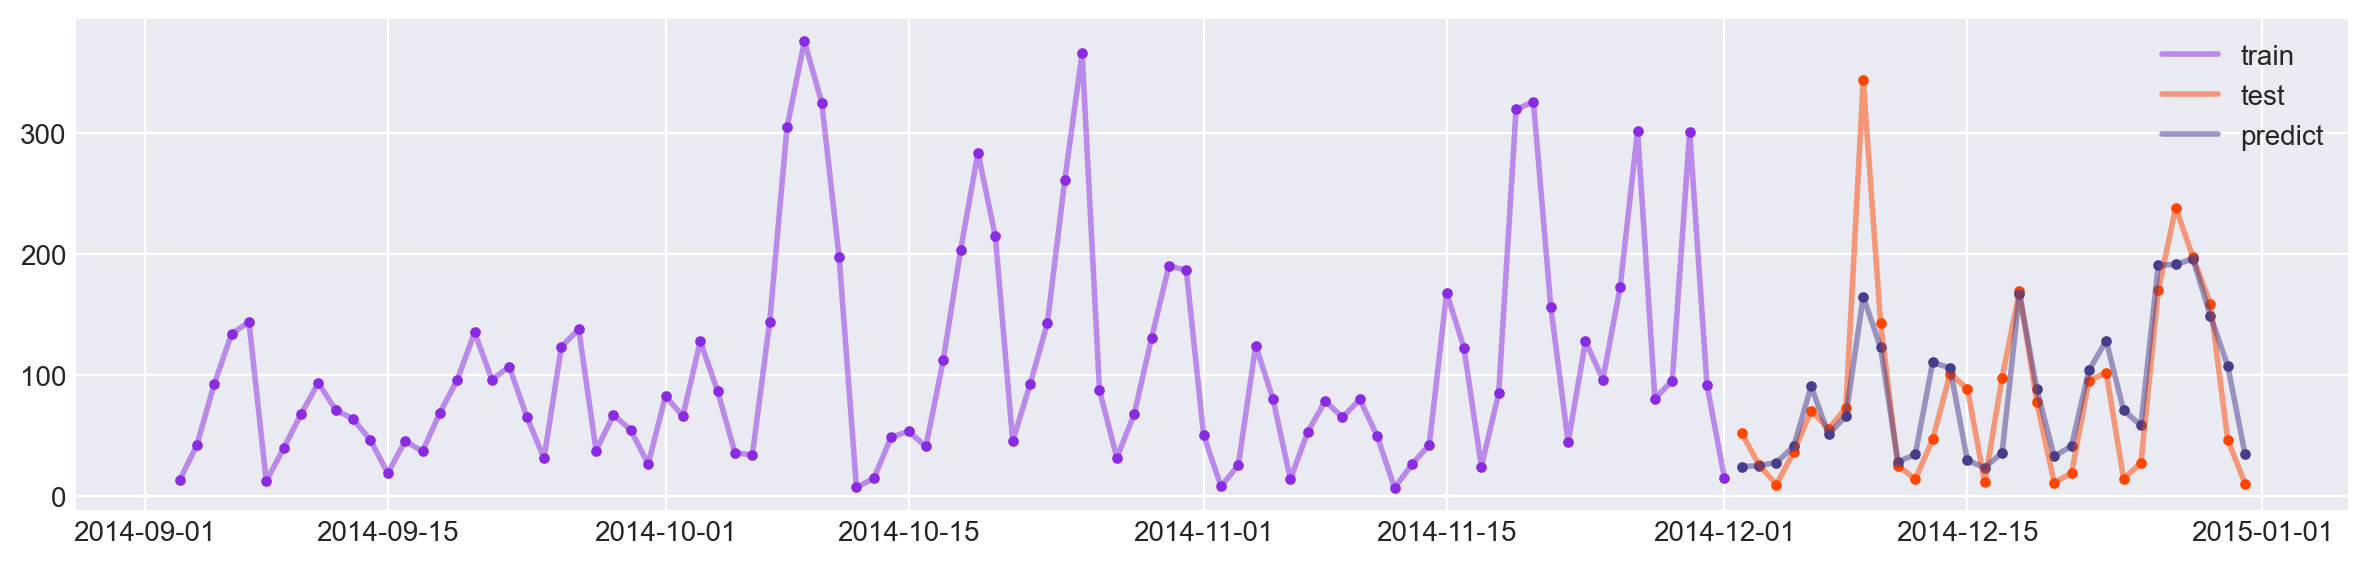

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [23]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [24]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Preparation for LSTM

In [25]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1825, 7)
dataframe shape after Feature Union (1822, 26)

data_x shape after seperate_target (1822, 25)
data_y shape after seperate_target (1822, 1)

data_x shape after StandardScaler (1822, 25)
data_y shape after StandardScaler (1822, 1)

x_window shape after Windowing (1799, 24, 25)
y_window shape after Windowing (1799, 1)

x_train_data shape after Test Train Split (1769, 24, 25)
x_test_data  shape after Test Train Split (30, 24, 25)
y_train_data shape after Test Train Split (1769, 1)
y_test_data  shape after Test Train Split (30, 1)



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

In [ ]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")

In [ ]:
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

In [ ]:
plot_tf_training_history(training_history)

In [ ]:
len(y_train_data_scaled)

In [ ]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [27]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor
mae,49.397917,33.699082,33.359555,27.935656,28.867486,28.521675,28.417162
rmse,68.728511,54.334663,54.202627,47.306770,47.167799,42.586825,44.484749
mape,1.312739,0.750188,0.798034,0.554420,0.568121,0.756319,0.740529
r2,0.223663,0.514790,0.517145,0.632191,0.634348,0.701924,0.674764


In [28]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,49.397917,68.728511,1.312739,0.223663
BayesianRidge,33.699082,54.334663,0.750188,0.514790
LassoCV,33.359555,54.202627,0.798034,0.517145
RandomForestRegressor,27.935656,47.306770,0.554420,0.632191
XGBRegressor,28.867486,47.167799,0.568121,0.634348
LGBMRegressor,28.521675,42.586825,0.756319,0.701924
CatBoostRegressor,28.417162,44.484749,0.740529,0.674764


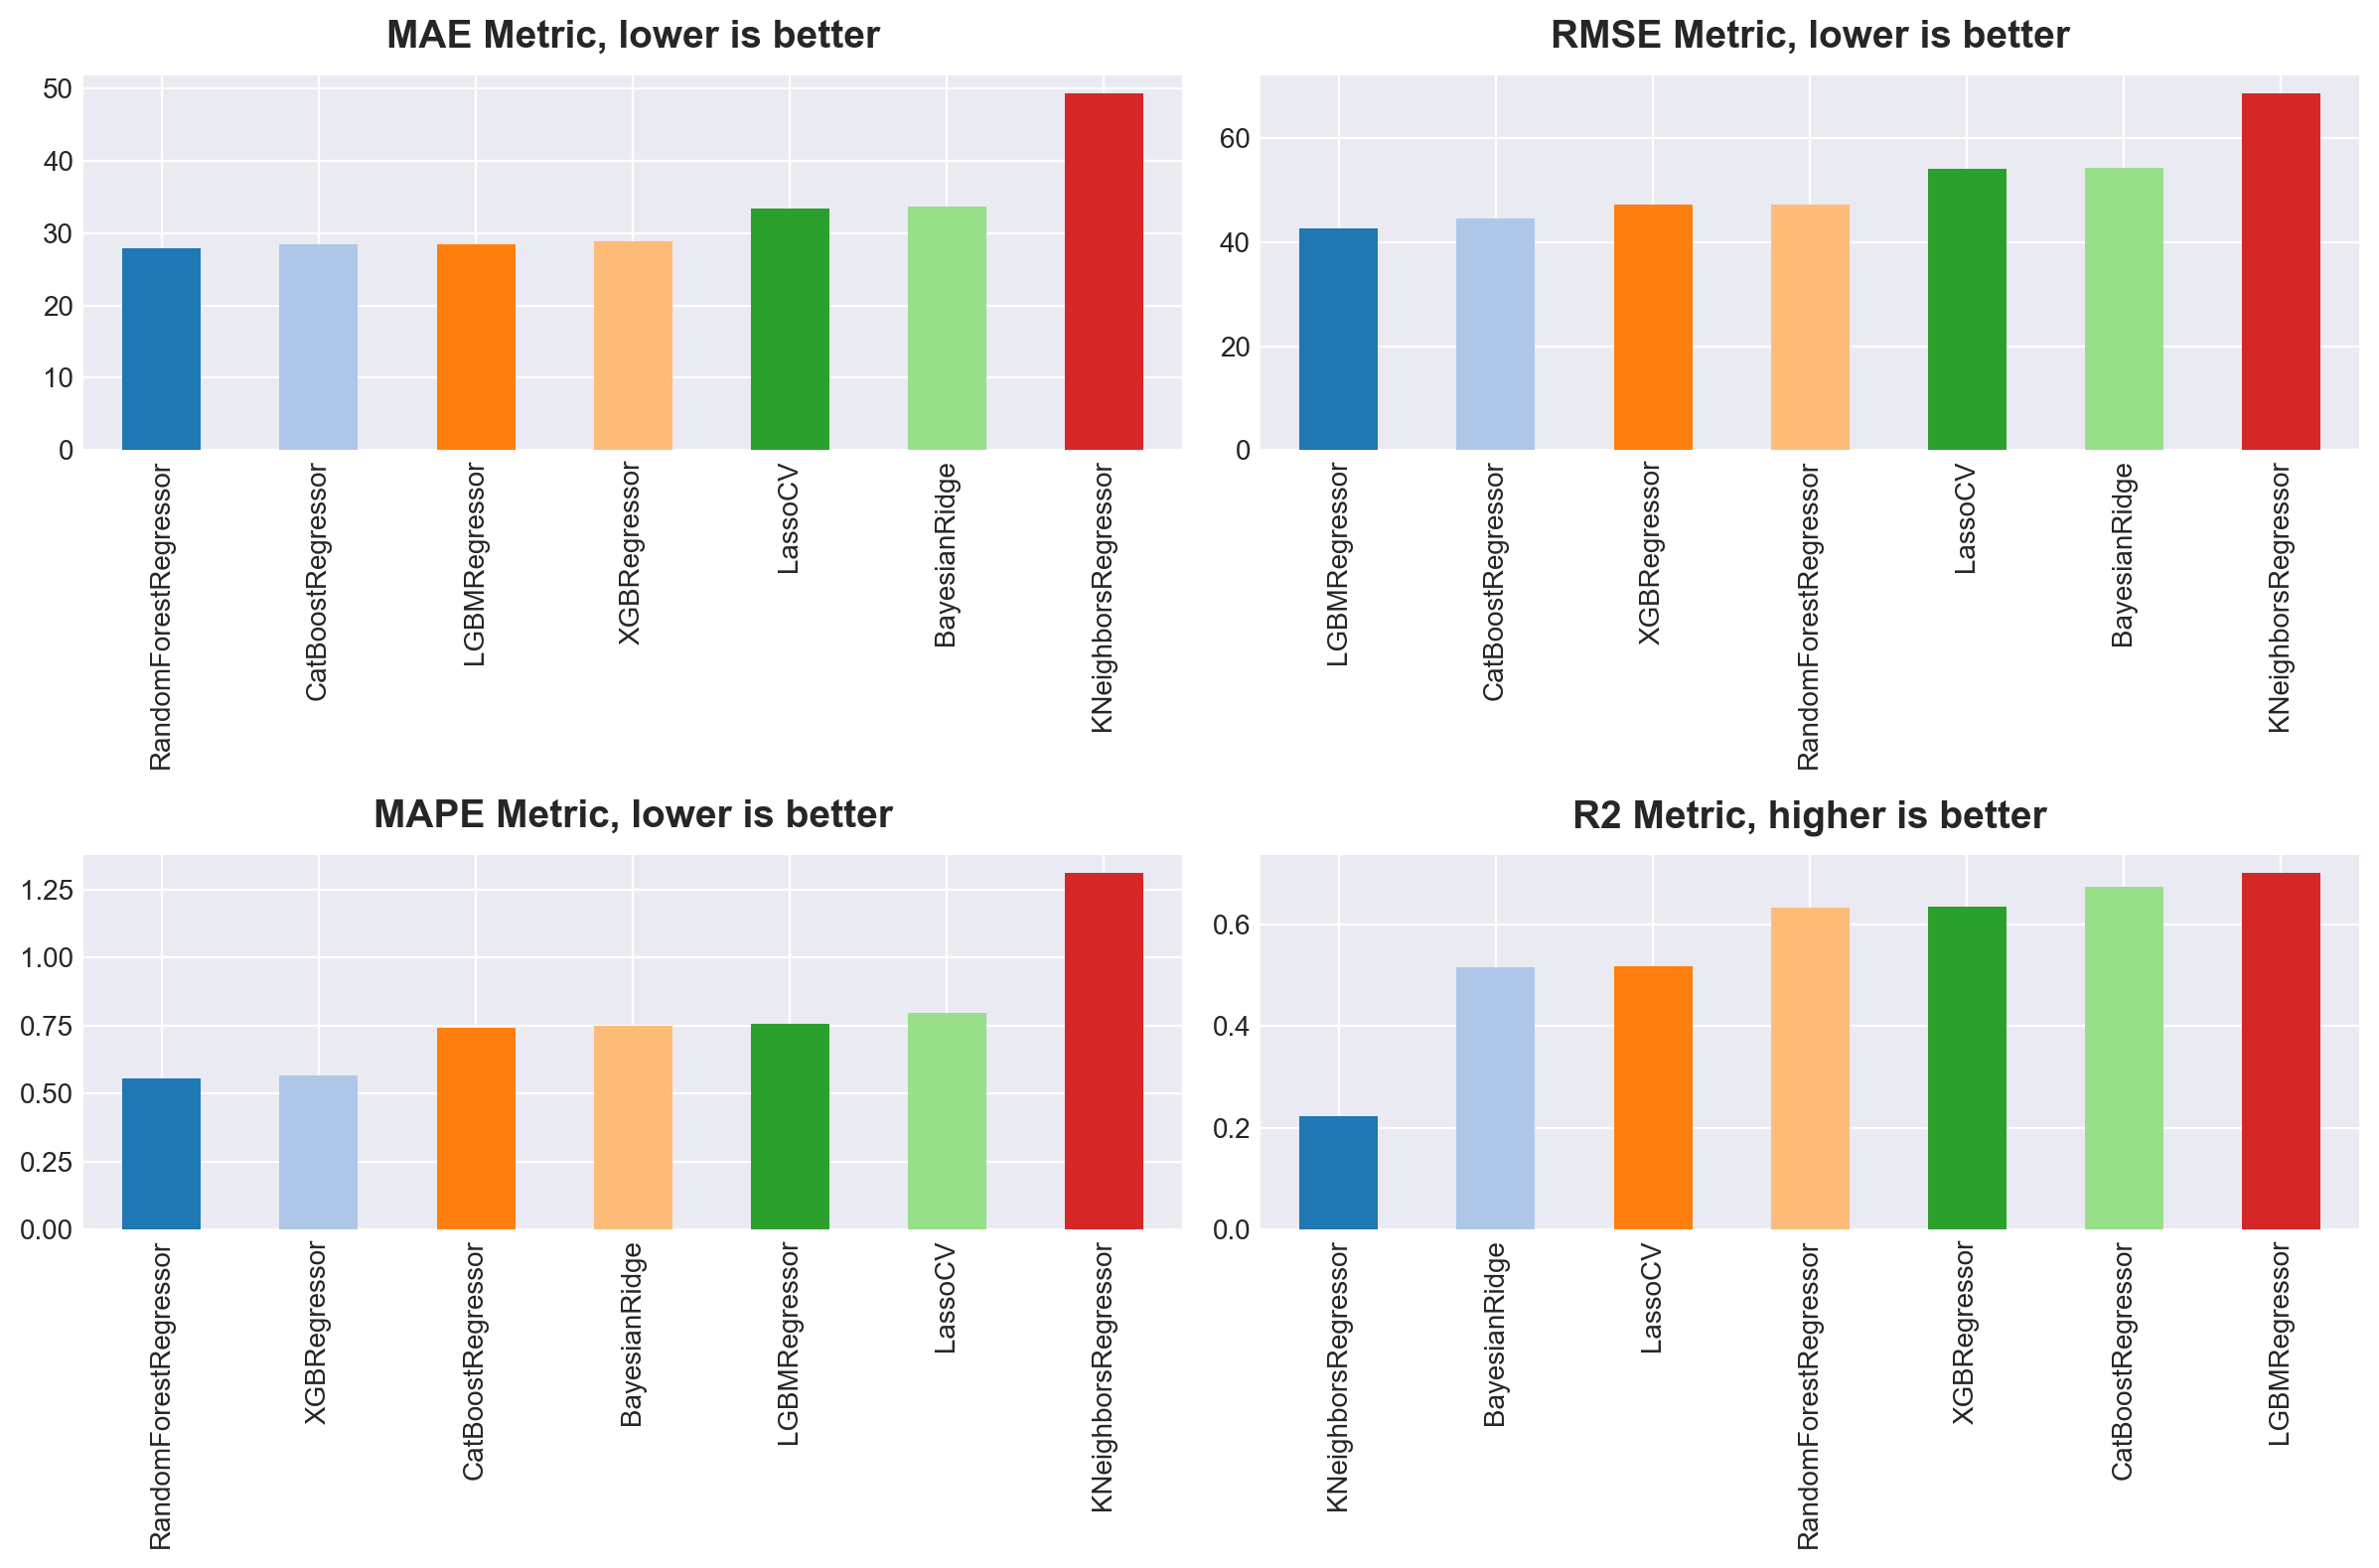

In [29]:
plot_metrics(resultsDF)

In [ ]:
resultsDF_T = resultsDF.T.copy(deep=True)

resultsDF_T["Dataset"] = "Air_Polution"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"


if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Air_Polution"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Air_Polution"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)